# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(28,28),self.img.reshape(28,28))

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = 1-ssim(self.X_best.reshape(28,28),self.img.reshape(28,28))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [5]:
model.load_weights('CNN_MNIST.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

# Prepare Data

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#def prepare_data(X,y):
 # X = X.reshape((X.shape[0], -1))
 # X_sc = X / 255.0
 # y_cat = to_categorical(y)
 # return X_sc, y_cat

In [8]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_sc = X_train / 255.0
y_cat = to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0
y_pred_test = model.predict(np.expand_dims(X_test_sc.reshape(X_test_sc.shape[0],28,28),axis=3))
y_pred_train = model.predict(np.expand_dims(X_sc.reshape(X_sc.shape[0],28,28),axis=3))
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.9942333333333333
Test accuracy:  0.9907


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,28,1,5,10,10000)

In [11]:
subsample.shape

(1021, 784)

In [12]:
subsample_y.shape

(1021,)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],28,28),axis=3))

In [14]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.9892262487757101


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)

In [16]:
original.shape

(895, 784)

In [17]:
adversarial.shape

(126, 784)

In [18]:
adversarial_y.shape

(126,)

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 100, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


25  :  0.6809241687647032 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


50  :  0.7705742796002623 25
75  :  0.75340370927931 25
100  :  0.75340370927931 25
125  :  0.75340370927931 25
150  :  0.75340370927931 25
175  :  0.75340370927931 25
200  :  0.75340370927931 25
225  :  0.75340370927931 25
250  :  0.75340370927931 25
275  :  0.7546437741570675 25
300  :  0.7560209474134258 25
325  :  0.7596669180971011 25
350  :  0.7596669180971011 25
375  :  0.7647278676923699 25
400  :  0.7686095912106424 25
425  :  0.7686431772412241 25
450  :  0.7708109536813734 25
475  :  0.7735347560184698 25
500  :  0.7739579190154988 25
525  :  0.7739579190154988 25
550  :  0.7757210589383194 25
575  :  0.7767414985468997 25
600  :  0.776709783729522 25
625  :  0.776709783729522 25
650  :  0.776709783729522 25
675  :  0.7768579925406014 25
700  :  0.7800762401473447 25
725  :  0.7798476438126304 25
750  :  0.7818970072407447 25
775  :  0.7818970072407447 25
800  :  0.7818970072407447 25
825  :  0.78620492694304 25
850  :  0.7863513029300473 25
Time:  60.426819801330566  second

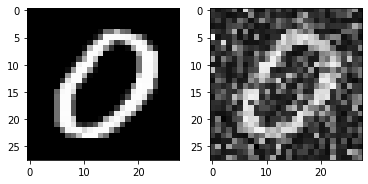

25  :  -0.04144798506264241 25
50  :  0.12909403829835114 25
75  :  0.15764698292707935 25
100  :  0.627176782742394 25
125  :  0.7045041376831476 25
150  :  0.7314094895528557 25
175  :  0.7377710233827806 25
200  :  0.7399753416425755 25
225  :  0.7468689433440093 25
250  :  0.7444339472244614 25
275  :  0.7444339472244614 25
300  :  0.7444339472244614 25
325  :  0.7444339472244614 25
350  :  0.7444339472244614 25
375  :  0.7444339472244614 25
400  :  0.7444339472244614 25
425  :  0.7453361436671635 25
450  :  0.7486597167002426 25
475  :  0.747888236972216 25
500  :  0.7508030033945403 25
525  :  0.7505486895493021 25
550  :  0.7505486895493021 25
575  :  0.7528027216957585 25
600  :  0.7526576813241893 25
625  :  0.7544390301262214 25
650  :  0.7567951846857184 25
675  :  0.7578246489514454 25
700  :  0.7583224296996485 25
725  :  0.7612967718943882 25
750  :  0.7617811095581604 25
775  :  0.7617811095581604 25
800  :  0.7617811095581604 25
825  :  0.7617811095581604 25
850  :  0.7

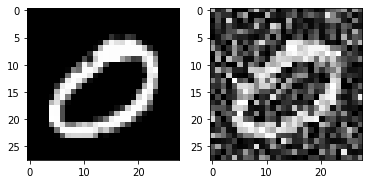

25  :  0.5745265193265403 25
50  :  0.7213683259784092 25
75  :  0.7001830763156989 25
100  :  0.7067475962998981 25
125  :  0.7144294268288911 25
150  :  0.7044193272632703 25
175  :  0.7336404466086079 25
200  :  0.7476717707279765 25
225  :  0.7476717707279765 25
250  :  0.7476717707279765 25
275  :  0.7476717707279765 25
300  :  0.7476717707279765 25
325  :  0.7476717707279765 25
350  :  0.7476717707279765 25
375  :  0.7500825747494171 25
400  :  0.7484913185044655 25
425  :  0.7484913185044655 25
450  :  0.7484913185044655 25
475  :  0.7495601405220096 25
500  :  0.7495601405220096 25
525  :  0.7495601405220096 25
550  :  0.7495601405220096 25
575  :  0.7495601405220096 25
600  :  0.7495601405220096 25
625  :  0.752576415718186 25
650  :  0.7528091891844853 25
675  :  0.7547052321296268 25
700  :  0.7535564153215135 25
725  :  0.7551717481024867 25
750  :  0.7570142887008051 25
775  :  0.756860953159683 25
800  :  0.756860953159683 25
825  :  0.7573517425073824 25
850  :  0.757670

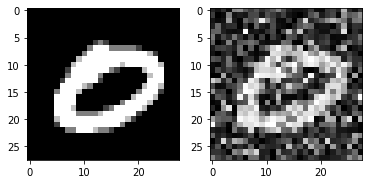

25  :  0.7413201996592406 25
50  :  0.7477637917451667 25
75  :  0.7397254153301251 25
100  :  0.7586877513074564 25
125  :  0.7485577858421019 25
150  :  0.7485577858421019 25
175  :  0.7485577858421019 25
200  :  0.7485577858421019 25
225  :  0.7485577858421019 25
250  :  0.7485577858421019 25
275  :  0.74884801133554 25
300  :  0.7529833010634532 25
325  :  0.7526452343572333 25
350  :  0.7526452343572333 25
375  :  0.7526452343572333 25
400  :  0.7528489690618958 25
425  :  0.7591795851771403 25
450  :  0.7594905908680094 25
475  :  0.7594905908680094 25
500  :  0.7594905908680094 25
525  :  0.761656784342134 25
550  :  0.7649336333704366 25
575  :  0.765036885921263 25
600  :  0.7663878108972204 25
625  :  0.7663878108972204 25
650  :  0.767598178526916 25
675  :  0.767598178526916 25
700  :  0.7685828345588612 25
725  :  0.7688747639640819 25
750  :  0.7698656458563864 25
775  :  0.7706813728993769 25
800  :  0.7710337156959794 25
825  :  0.7710337156959794 25
850  :  0.771394253

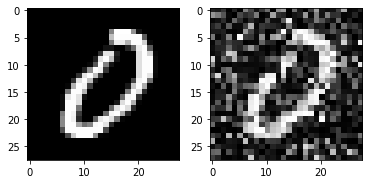

25  :  0.6537514043807573 25
50  :  0.6980791128910847 25
75  :  0.7474879568137086 25
100  :  0.7436681379513452 25
125  :  0.7436681379513452 25
150  :  0.7436681379513452 25
175  :  0.7436681379513452 25
200  :  0.7436681379513452 25
225  :  0.7436681379513452 25
250  :  0.7441488560690777 25
275  :  0.7441488560690777 25
300  :  0.748403789039178 25
325  :  0.748403789039178 25
350  :  0.748403789039178 25
375  :  0.751250367603816 25
400  :  0.7559024439627178 25
425  :  0.7575343996919586 25
450  :  0.7575343996919586 25
475  :  0.7603575046455247 25
500  :  0.7621302112454716 25
525  :  0.7631525518409297 25
550  :  0.7648064300710855 25
575  :  0.7647801711634938 25
600  :  0.7651220125451001 25
625  :  0.7651971176710461 25
650  :  0.7653503322445123 25
675  :  0.7669130314211511 25
700  :  0.7686014128241245 25
725  :  0.7683212902651471 25
750  :  0.7683788142413321 25
775  :  0.7683810133799633 25
800  :  0.7685364492307734 25
825  :  0.7687470209034657 25
850  :  0.7689083

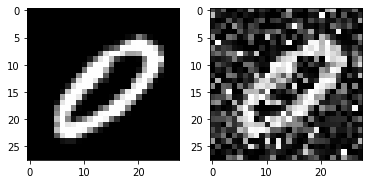

25  :  0.7439845237922438 25
50  :  0.7439845237922438 25
75  :  0.7439845237922438 25
100  :  0.7477974433002682 25
125  :  0.7439845237922438 25
150  :  0.7526561510783922 25
175  :  0.7561945527301905 25
200  :  0.7523237774746051 25
225  :  0.7523237774746051 25
250  :  0.753416981004942 25
275  :  0.753416981004942 25
300  :  0.7563807646457722 25
325  :  0.7564375370178755 25
350  :  0.7585161505305686 25
375  :  0.7585161505305686 25
400  :  0.7618899499204815 25
425  :  0.7635919681242054 25
450  :  0.7662135970478516 25
475  :  0.7700322315598513 25
500  :  0.7700322315598513 25
525  :  0.7738449484193629 25
550  :  0.774837753284954 25
575  :  0.774837753284954 25
600  :  0.774837753284954 25
625  :  0.774837753284954 25
650  :  0.7752549768736468 25
675  :  0.7764945170360902 25
700  :  0.7794829425431509 25
725  :  0.7817735992848587 25
750  :  0.7819729555544803 25
775  :  0.7819729555544803 25
800  :  0.7828069207532362 25
Time:  55.84380888938904  seconds
Predicted class

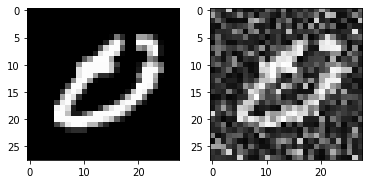

25  :  0.45012424423977004 25
50  :  0.45012424423977004 25
75  :  0.45012424423977004 25
100  :  0.5850972894459938 25
125  :  0.7319365019573258 25
150  :  0.7150496921214768 25
175  :  0.7150496921214768 25
200  :  0.7297685674380883 25
225  :  0.7297685674380883 25
250  :  0.7297685674380883 25
275  :  0.7297685674380883 25
300  :  0.7297685674380883 25
325  :  0.7297685674380883 25
350  :  0.7297685674380883 25
375  :  0.7297685674380883 25
400  :  0.7297685674380883 25
425  :  0.7372835320251906 25
450  :  0.7372835320251906 25
475  :  0.7372835320251906 25
500  :  0.7372835320251906 25
525  :  0.7372835320251906 25
550  :  0.7372835320251906 25
575  :  0.7372835320251906 25
600  :  0.7372835320251906 25
625  :  0.7372835320251906 25
650  :  0.7427077936475512 25
675  :  0.7455711540250505 25
700  :  0.7577513779196356 25
725  :  0.7598504587253033 25
750  :  0.7601579264512691 25
775  :  0.7601579264512691 25
800  :  0.7601579264512691 25
825  :  0.7601579264512691 25
850  :  0.

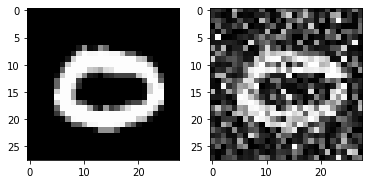

25  :  0.5804456291713207 25
50  :  0.6775863583634949 25
75  :  0.689160858541643 25
100  :  0.7227135789597267 25
125  :  0.7130676971924031 25
150  :  0.7134424000010025 25
175  :  0.7118551966370431 25
200  :  0.7174012366426014 25
225  :  0.7147484751441017 25
250  :  0.7147484751441017 25
275  :  0.7147484751441017 25
300  :  0.717872366710524 25
325  :  0.717872366710524 25
350  :  0.717872366710524 25
375  :  0.7207409895195329 25
400  :  0.7206785488514594 25
425  :  0.721451906092226 25
450  :  0.7206785488514594 25
475  :  0.7271693230081445 25
500  :  0.7287554111765839 25
525  :  0.7319389730643036 25
550  :  0.7329231687568071 25
575  :  0.7348096054843617 25
600  :  0.7348096054843617 25
625  :  0.7348096054843617 25
650  :  0.7382349171202387 25
675  :  0.7381007402938202 25
700  :  0.738483729213326 25
725  :  0.7404072650837572 25
750  :  0.7408336297159042 25
775  :  0.7443112213676287 25
800  :  0.7441567665617528 25
825  :  0.7441567665617528 25
850  :  0.744156766

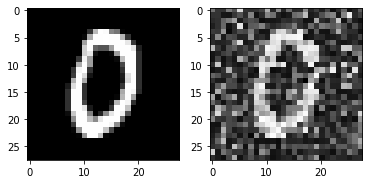

25  :  0.6755639628069448 25
50  :  0.676156423107997 25
75  :  0.6933716420678626 25
100  :  0.68279754581499 25
125  :  0.6952501030463567 25
150  :  0.6917937331239523 25
175  :  0.6917937331239523 25
200  :  0.6923851115535771 25
225  :  0.6923851115535771 25
250  :  0.6923851115535771 25
275  :  0.6961227535773601 25
300  :  0.6971571781031655 25
325  :  0.6977553263776665 25
350  :  0.699178788291479 25
375  :  0.7019261451553027 25
400  :  0.7048615676121193 25
425  :  0.7044967347765146 25
450  :  0.7044967347765146 25
475  :  0.7044967347765146 25
500  :  0.7044967347765146 25
525  :  0.7070567916110708 25
550  :  0.709984867895942 25
575  :  0.7101909752907265 25
600  :  0.7126303839220727 25
625  :  0.7126181995053805 25
650  :  0.714555367226613 25
675  :  0.7145912796629215 25
700  :  0.7146245904065124 25
725  :  0.7157044504362988 25
750  :  0.7159461173308432 25
775  :  0.7164256279798602 25
800  :  0.7167132971119368 25
825  :  0.7167132971119368 25
850  :  0.716899751

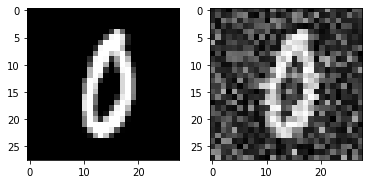

25  :  0.7089167457728586 25
50  :  0.7089167457728586 25
75  :  0.7187544314595852 25
100  :  0.7213721838141212 25
125  :  0.717616948865161 25
150  :  0.7234954501541759 25
175  :  0.7208146874929521 25
200  :  0.726059723506089 25
225  :  0.726059723506089 25
250  :  0.726059723506089 25
275  :  0.726059723506089 25
300  :  0.7263257471715432 25
325  :  0.726059723506089 25
350  :  0.7273291988646662 25
375  :  0.7276944119723596 25
400  :  0.7327518983354584 25
425  :  0.7343473932992542 25
450  :  0.7343473932992542 25
475  :  0.7343473932992542 25
500  :  0.7388742166343732 25
525  :  0.740810020416973 25
550  :  0.7445370622068307 25
575  :  0.745886775300727 25
600  :  0.7476358389200997 25
625  :  0.7492187299825157 25
650  :  0.7503974840783005 25
675  :  0.7513696962432943 25
700  :  0.7518240507093781 25
725  :  0.7521167641453421 25
750  :  0.7522014096087782 25
775  :  0.7534864085907518 25
800  :  0.7534730308824331 25
Time:  64.21229696273804  seconds
Predicted class: 

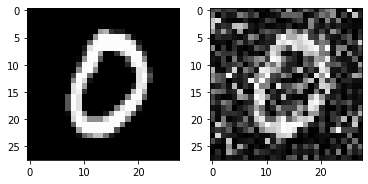

25  :  0.7929720360076993 25
50  :  0.7929720360076993 25
75  :  0.7908799229771034 25
100  :  0.7908799229771034 25
125  :  0.7908799229771034 25
150  :  0.7914702717002299 25
175  :  0.7914702717002299 25
200  :  0.7914702717002299 25
225  :  0.7914702717002299 25
250  :  0.7914702717002299 25
275  :  0.8020113221094067 25
300  :  0.8020113221094067 25
325  :  0.8020113221094067 25
350  :  0.8020113221094067 25
375  :  0.8075704016046741 25
400  :  0.8074696824487299 25
425  :  0.8074696824487299 25
450  :  0.8074696824487299 25
475  :  0.8076838079898023 25
500  :  0.8087289159255768 25
525  :  0.8109964057969382 25
550  :  0.8108991965615499 25
575  :  0.8147612994712958 25
600  :  0.8147610325353225 25
625  :  0.8147610325353225 25
650  :  0.8188688319176027 25
675  :  0.8188688319176027 25
700  :  0.8188688319176027 25
725  :  0.8203001893626498 25
750  :  0.82028790433755 25
775  :  0.82028790433755 25
800  :  0.8215692103532106 25
825  :  0.8228887072444591 25
850  :  0.8231170

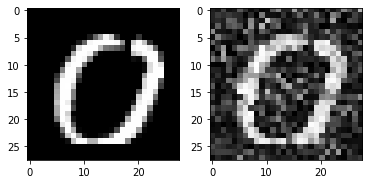

25  :  -0.017944475161944196 25
50  :  0.590542849641541 25
75  :  0.7247745459070893 25
100  :  0.7095376380587194 25
125  :  0.7265834832394095 25
150  :  0.7261728866997601 25
175  :  0.7261728866997601 25
200  :  0.7261728866997601 25
225  :  0.7261728866997601 25
250  :  0.7261728866997601 25
275  :  0.7261728866997601 25
300  :  0.7261728866997601 25
325  :  0.7261728866997601 25
350  :  0.7261728866997601 25
375  :  0.7261728866997601 25
400  :  0.7261728866997601 25
425  :  0.7261728866997601 25
450  :  0.7261728866997601 25
475  :  0.7282923732178986 25
500  :  0.7295372098707427 25
525  :  0.7338863143749935 25
550  :  0.7385465933444483 25
575  :  0.7441337225769817 25
600  :  0.7441159917560071 25
625  :  0.7441159917560071 25
650  :  0.7487888586391771 25
675  :  0.7512028541495177 25
700  :  0.7509782453479716 25
725  :  0.7513690173484135 25
750  :  0.752482879831111 25
775  :  0.7524650975704694 25
800  :  0.7524650975704694 25
825  :  0.7546059474373246 25
850  :  0.75

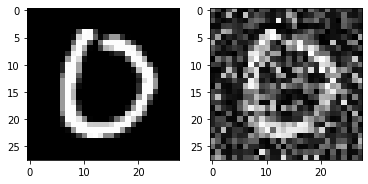

25  :  0.7763385435563874 25
50  :  0.7781885067163719 25
75  :  0.7810367048081912 25
100  :  0.7869921163923015 25
125  :  0.7873532796342891 25
150  :  0.7921167345700761 25
175  :  0.7910977633258809 25
200  :  0.7976987702081026 25
225  :  0.7979258429732254 25
250  :  0.7979258429732254 25
275  :  0.8066998573209805 25
300  :  0.8067248623337179 25
325  :  0.8067248623337179 25
350  :  0.8098776019064322 25
375  :  0.8126403549569786 25
400  :  0.8126754294285803 25
425  :  0.8126754294285803 25
450  :  0.8126754294285803 25
475  :  0.8138146747956216 25
500  :  0.8138146747956216 25
525  :  0.8165244505253554 25
550  :  0.8170982945746105 25
575  :  0.8170982945746105 25
600  :  0.8191795581743808 25
625  :  0.8191760031086861 25
650  :  0.8191760031086861 25
675  :  0.8198178988141454 25
700  :  0.8202143629171967 25
725  :  0.8202143629171967 25
750  :  0.8202143629171967 25
775  :  0.8202197559709999 25
800  :  0.8209569379463821 25
Time:  68.36725449562073  seconds
Predicted

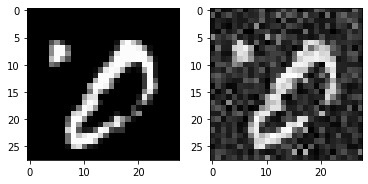

25  :  0.6326907902143643 25
50  :  0.6326907902143643 25
75  :  0.6349454434253564 25
100  :  0.6339898047185109 25
125  :  0.6387831351964718 25
150  :  0.6387831351964718 25
175  :  0.6387831351964718 25
200  :  0.6414741435600165 25
225  :  0.6414741435600165 25
250  :  0.6414741435600165 25
275  :  0.6414741435600165 25
300  :  0.643735292646309 25
325  :  0.6444183733451468 25
350  :  0.6467356425518935 25
375  :  0.6461281369373402 25
400  :  0.6461281369373402 25
425  :  0.64728717196397 25
450  :  0.6480317746822973 25
475  :  0.6480317746822973 25
500  :  0.6480317746822973 25
525  :  0.6489228935503888 25
550  :  0.6489984647720043 25
575  :  0.6489984647720043 25
600  :  0.6489984647720043 25
625  :  0.6492811141060026 25
650  :  0.6492811141060026 25
675  :  0.6494557045196712 25
700  :  0.6495680486168302 25
725  :  0.6502098882038713 25
750  :  0.6506869015793717 25
775  :  0.6509594445791494 25
800  :  0.6509778588581101 25
Time:  68.6444263458252  seconds
Predicted cla

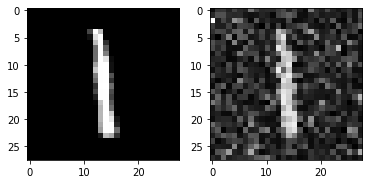

25  :  0.6338911980679063 25
50  :  0.6338911980679063 25
75  :  0.6351366446977125 25
100  :  0.6375153097375224 25
125  :  0.6378101741229443 25
150  :  0.6447926531194688 25
175  :  0.6447926531194688 25
200  :  0.6447926531194688 25
225  :  0.6447926531194688 25
250  :  0.6450675593239444 25
275  :  0.6448773310245608 25
300  :  0.6448773310245608 25
325  :  0.6458932683870096 25
350  :  0.6456841097480664 25
375  :  0.646783700990481 25
400  :  0.6474108458653314 25
425  :  0.6475211022764944 25
450  :  0.6512776366591388 25
475  :  0.6512776366591388 25
500  :  0.6512776366591388 25
525  :  0.6512776366591388 25
550  :  0.6512776366591388 25
575  :  0.6523380952566504 25
600  :  0.6523372339427781 25
625  :  0.6523372339427781 25
650  :  0.6525949417789783 25
675  :  0.6524653406262059 25
700  :  0.6535875426634564 25
725  :  0.653585101681741 25
750  :  0.6537915677761186 25
775  :  0.653983827537743 25
800  :  0.6540765157713242 25
Time:  66.86289501190186  seconds
Predicted cl

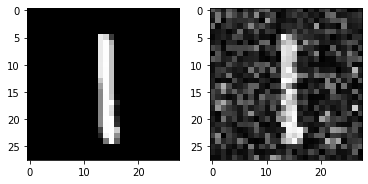

25  :  0.5988632561123779 25
50  :  0.5988632561123779 25
75  :  0.6000158769012115 25
100  :  0.5970730455113948 25
125  :  0.5973961040705669 25
150  :  0.5970730455113948 25
175  :  0.5970730455113948 25
200  :  0.6023826072007638 25
225  :  0.6022471936571323 25
250  :  0.6022471936571323 25
275  :  0.6022471936571323 25
300  :  0.6022471936571323 25
325  :  0.6022471936571323 25
350  :  0.6059780255359665 25
375  :  0.6059780255359665 25
400  :  0.6074340166562321 25
425  :  0.6078818493088222 25
450  :  0.6129159224197669 25
475  :  0.6129159224197669 25
500  :  0.6129159224197669 25
525  :  0.6129159224197669 25
550  :  0.6129159224197669 25
575  :  0.6129159224197669 25
600  :  0.6133470144051527 25
625  :  0.6133470144051527 25
650  :  0.6133470144051527 25
675  :  0.6133470144051527 25
700  :  0.6133470144051527 25
725  :  0.6133470144051527 25
750  :  0.6133470144051527 25
775  :  0.6133470144051527 25
800  :  0.6133470144051527 25
Time:  65.67609667778015  seconds
Predicted

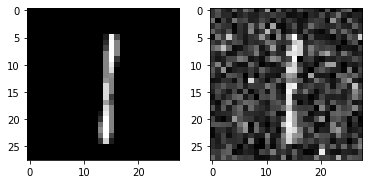

25  :  0.6311371609763428 25
50  :  0.6365521634867002 25
75  :  0.6355558526017204 25
100  :  0.6346146313185688 25
125  :  0.6346146313185688 25
150  :  0.6376186513827955 25
175  :  0.6346146313185688 25
200  :  0.6346146313185688 25
225  :  0.6348493115204793 25
250  :  0.6367730652181499 25
275  :  0.6353387593479062 25
300  :  0.6353387593479062 25
325  :  0.6353387593479062 25
350  :  0.636191635230782 25
375  :  0.636191635230782 25
400  :  0.6363045096803427 25
425  :  0.6377535916702769 25
450  :  0.6377535916702769 25
475  :  0.6377535916702769 25
500  :  0.6390191396403366 25
525  :  0.6390191396403366 25
550  :  0.6399198713787148 25
575  :  0.6404588094901504 25
600  :  0.6408354259864464 25
625  :  0.6408354259864464 25
650  :  0.6408354259864464 25
675  :  0.6425740116180895 25
700  :  0.6443665822946549 25
725  :  0.6442517770186422 25
750  :  0.6448040241325479 25
775  :  0.6448040241325479 25
800  :  0.6448040241325479 25
Time:  60.14332675933838  seconds
Predicted c

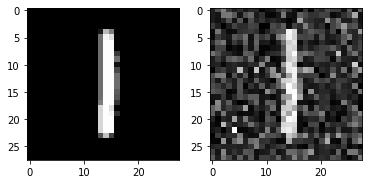

25  :  0.6721112764800756 25
50  :  0.6721112764800756 25
75  :  0.6721112764800756 25
100  :  0.6721112764800756 25
125  :  0.6721112764800756 25
150  :  0.6721112764800756 25
175  :  0.6724961218893596 25
200  :  0.6730610033519057 25
225  :  0.6734305712991959 25
250  :  0.6726978503008769 25
275  :  0.6746329159951987 25
300  :  0.6755497053429094 25
325  :  0.675281547638664 25
350  :  0.6753763254233023 25
375  :  0.6770171640068503 25
400  :  0.6768178549417863 25
425  :  0.6768178549417863 25
450  :  0.6768178549417863 25
475  :  0.6777703399888656 25
500  :  0.6777703399888656 25
525  :  0.6777703399888656 25
550  :  0.6777703399888656 25
575  :  0.6777703399888656 25
600  :  0.6777703399888656 25
625  :  0.6777703399888656 25
650  :  0.6780732519549727 25
675  :  0.678310947481114 25
700  :  0.6781829192151988 25
725  :  0.6786403598863046 25
750  :  0.6790038828508964 25
775  :  0.6790918703025084 25
800  :  0.6794748908616843 25
Time:  67.82071232795715  seconds
Predicted c

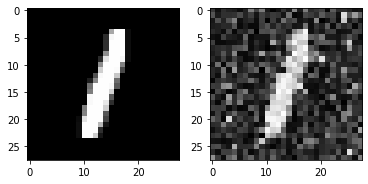

25  :  0.6527595010136366 25
50  :  0.6527595010136366 25
75  :  0.6591988432226465 25
100  :  0.6610505651973656 25
125  :  0.6610505651973656 25
150  :  0.6610505651973656 25
175  :  0.6610505651973656 25
200  :  0.6610505651973656 25
225  :  0.6610505651973656 25
250  :  0.6610505651973656 25
275  :  0.6621497353884409 25
300  :  0.6628860841462884 25
325  :  0.6658431474914325 25
350  :  0.6693647177949422 25
375  :  0.6695221173688293 25
400  :  0.6695221173688293 25
425  :  0.6695221173688293 25
450  :  0.6697171771434852 25
475  :  0.6701185011265245 25
500  :  0.6707598281931835 25
525  :  0.670805545520327 25
550  :  0.6723766956286319 25
575  :  0.6723836413314825 25
600  :  0.6723845170179623 25
625  :  0.6734772675184864 25
650  :  0.6734802775530476 25
675  :  0.6734802775530476 25
700  :  0.6736893868689878 25
725  :  0.6746505718041608 25
750  :  0.6746501016895795 25
775  :  0.6747456026211297 25
800  :  0.6752545969299025 25
Time:  67.20090436935425  seconds
Predicted 

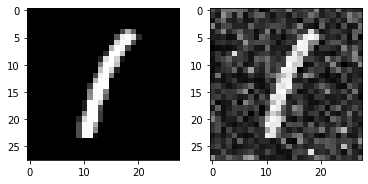

25  :  0.6306132141444711 25
50  :  0.6306132141444711 25
75  :  0.6321202247052737 25
100  :  0.636192781937252 25
125  :  0.6351219585375891 25
150  :  0.6369497681595954 25
175  :  0.635800373394502 25
200  :  0.635800373394502 25
225  :  0.635800373394502 25
250  :  0.635800373394502 25
275  :  0.6365212115092171 25
300  :  0.6370047050521165 25
325  :  0.6365212115092171 25
350  :  0.6411038086905134 25
375  :  0.6404761998508063 25
400  :  0.6404761998508063 25
425  :  0.6404761998508063 25
450  :  0.6404761998508063 25
475  :  0.6404761998508063 25
500  :  0.6454062052034041 25
525  :  0.6449311419314901 25
550  :  0.645755452158179 25
575  :  0.6482065078575483 25
600  :  0.645755452158179 25
625  :  0.645755452158179 25
650  :  0.645755452158179 25
675  :  0.645755452158179 25
700  :  0.645755452158179 25
725  :  0.6470700654509012 25
750  :  0.6485770929102378 25
775  :  0.6470700654509012 25
800  :  0.6491044571605931 25
Time:  68.01611328125  seconds
Predicted class:  [2]


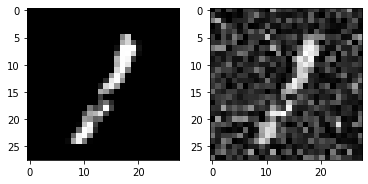

25  :  0.6385629152694885 25
50  :  0.6385629152694885 25
75  :  0.6385668992489234 25
100  :  0.6409824981643198 25
125  :  0.6456087828031404 25
150  :  0.6456417460481592 25
175  :  0.6456417460481592 25
200  :  0.6456417460481592 25
225  :  0.6473560448212023 25
250  :  0.6473560448212023 25
275  :  0.6502044829633067 25
300  :  0.6497777633535572 25
325  :  0.649841215489836 25
350  :  0.6497187200261964 25
375  :  0.6511255480546613 25
400  :  0.6497187200261964 25
425  :  0.6509844716756241 25
450  :  0.6523846221864341 25
475  :  0.6533496810792072 25
500  :  0.6533721542069799 25
525  :  0.6533721542069799 25
550  :  0.6533721542069799 25
575  :  0.6533721542069799 25
600  :  0.6533721542069799 25
625  :  0.6538272584147553 25
650  :  0.6539112757930584 25
675  :  0.6542796452211517 25
700  :  0.6551374512002895 25
725  :  0.6562764884072124 25
750  :  0.6564034199012589 25
775  :  0.6572968159334647 25
800  :  0.6579114051807491 25
Time:  69.20111846923828  seconds
Predicted 

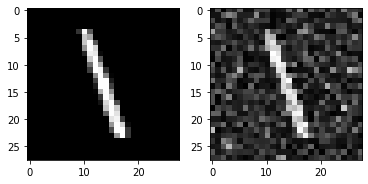

25  :  0.6542195830348269 25
50  :  0.6545064189786044 25
75  :  0.654463009945358 25
100  :  0.654463009945358 25
125  :  0.6571162326853703 25
150  :  0.6563620858314791 25
175  :  0.6563620858314791 25
200  :  0.6563620858314791 25
225  :  0.6563620858314791 25
250  :  0.6563620858314791 25
275  :  0.6565783939289321 25
300  :  0.6573574821410373 25
325  :  0.6573574821410373 25
350  :  0.6589877706137006 25
375  :  0.6585668991706801 25
400  :  0.6585668991706801 25
425  :  0.6585668991706801 25
450  :  0.6594710227830463 25
475  :  0.6605356120950114 25
500  :  0.6611057498512767 25
525  :  0.661627973775138 25
550  :  0.6616113512249749 25
575  :  0.6616113512249749 25
600  :  0.6620644704596818 25
625  :  0.6629081749917572 25
650  :  0.6629081749917572 25
675  :  0.6632963079898598 25
700  :  0.6638529360011022 25
725  :  0.6640302665234648 25
750  :  0.6640882032449601 25
775  :  0.6641075221259273 25
800  :  0.664349514663154 25
Time:  67.50551891326904  seconds
Predicted cla

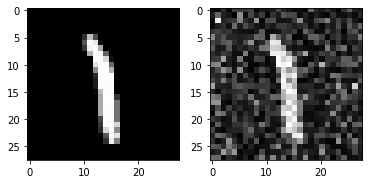

25  :  0.6244250624301826 25
50  :  0.6254113285982544 25
75  :  0.6238763654454713 25
100  :  0.6238763654454713 25
125  :  0.6238763654454713 25
150  :  0.6259510026391538 25
175  :  0.6320528477966973 25
200  :  0.6309227164525699 25
225  :  0.6309227164525699 25
250  :  0.6330105606792871 25
275  :  0.633673077187803 25
300  :  0.633673077187803 25
325  :  0.633673077187803 25
350  :  0.633673077187803 25
375  :  0.6340942809976766 25
400  :  0.634014345505292 25
425  :  0.6361322708587696 25
450  :  0.6361322708587696 25
475  :  0.6361322708587696 25
500  :  0.6379350497075129 25
525  :  0.6378450193263692 25
550  :  0.6378450193263692 25
575  :  0.63890338583667 25
600  :  0.6394519765963155 25
625  :  0.639391867805062 25
650  :  0.6395232700120634 25
675  :  0.640705773996757 25
700  :  0.6420844913435246 25
725  :  0.6420586133635555 25
750  :  0.642533651691795 25
775  :  0.642369562487273 25
800  :  0.6424356373976249 25
Time:  67.26696634292603  seconds
Predicted class:  [8

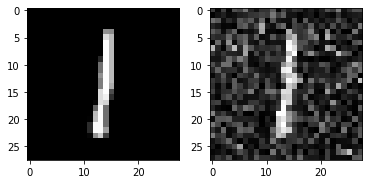

25  :  0.6511642833258613 25
50  :  0.6511642833258613 25
75  :  0.6511642833258613 25
100  :  0.6511642833258613 25
125  :  0.6511642833258613 25
150  :  0.6511642833258613 25
175  :  0.6511642833258613 25
200  :  0.6511642833258613 25
225  :  0.6511642833258613 25
250  :  0.6511642833258613 25
275  :  0.6516391279784629 25
300  :  0.654893534538096 25
325  :  0.6545655513766795 25
350  :  0.6545655513766795 25
375  :  0.6585022572342645 25
400  :  0.6557395562709075 25
425  :  0.6573923991634113 25
450  :  0.6575961563191018 25
475  :  0.6575961563191018 25
500  :  0.6598093097084697 25
525  :  0.658994294817804 25
550  :  0.658994294817804 25
575  :  0.6600371749811678 25
600  :  0.660094247322434 25
625  :  0.660094247322434 25
650  :  0.660094247322434 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


675  :  0.660094247322434 25
700  :  0.660094247322434 25
725  :  0.660094247322434 25
750  :  0.660094247322434 25
775  :  0.660094247322434 25
800  :  0.660094247322434 25
Time:  67.5964777469635  seconds
Predicted class:  [8]


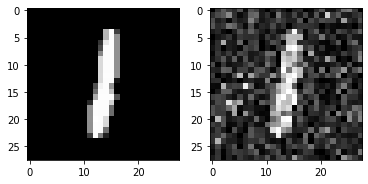

25  :  0.6134534548341325 25
50  :  0.6134534548341325 25
75  :  0.6177185241032211 25
100  :  0.6181227560310038 25
125  :  0.6191287301131827 25
150  :  0.619163109054455 25
175  :  0.6217025554371531 25
200  :  0.6204060079922001 25
225  :  0.6238900530342247 25
250  :  0.6223549371112959 25
275  :  0.6221159969739919 25
300  :  0.6221159969739919 25
325  :  0.6261484175311439 25
350  :  0.6252705944254127 25
375  :  0.6252705944254127 25
400  :  0.6285788038469289 25
425  :  0.6284625114933341 25
450  :  0.6284625114933341 25
475  :  0.6293803053388406 25
500  :  0.6294516626654627 25
525  :  0.6294516626654627 25
550  :  0.6296163580978887 25
575  :  0.6296163580978887 25
600  :  0.6306284160417934 25
625  :  0.6305076797071593 25
650  :  0.6305076797071593 25
675  :  0.6319926697307972 25
700  :  0.6325832064449419 25
725  :  0.6319926697307972 25
750  :  0.6319926697307972 25
775  :  0.6339555291812605 25
800  :  0.6338678808261473 25
Time:  68.54251408576965  seconds
Predicted 

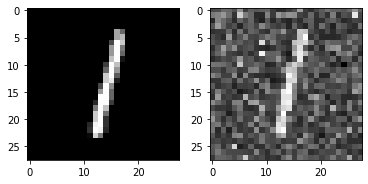

25  :  0.645609268827168 25
50  :  0.645609268827168 25
75  :  0.645609268827168 25
100  :  0.6478211709497715 25
125  :  0.645609268827168 25
150  :  0.6467678632886504 25
175  :  0.6495624414957506 25
200  :  0.6484277902189501 25
225  :  0.6484277902189501 25
250  :  0.6484277902189501 25
275  :  0.6500221717556491 25
300  :  0.6484277902189501 25
325  :  0.6484277902189501 25
350  :  0.6504347603957713 25
375  :  0.6504347603957713 25
400  :  0.6517920309786299 25
425  :  0.6517195993238717 25
450  :  0.6517195993238717 25
475  :  0.6521386003217998 25
500  :  0.6521386003217998 25
525  :  0.6521386003217998 25
550  :  0.6523579871158344 25
575  :  0.6557809758269137 25
600  :  0.654925769687333 25
625  :  0.654925769687333 25
650  :  0.654925769687333 25
675  :  0.654925769687333 25
700  :  0.654925769687333 25
725  :  0.654925769687333 25
750  :  0.655126342785949 25
775  :  0.655126342785949 25
800  :  0.6552283266567412 25
Time:  66.06244969367981  seconds
Predicted class:  [8]

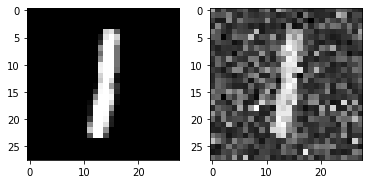

25  :  0.6485821113302177 25
50  :  0.6485821113302177 25
75  :  0.6502736130141199 25
100  :  0.6516635167241757 25
125  :  0.6559848550822116 25
150  :  0.6560493421032022 25
175  :  0.6570717076582531 25
200  :  0.6587475338753565 25
225  :  0.6593805823350658 25
250  :  0.6634904501998306 25
275  :  0.6634904501998306 25
300  :  0.6634904501998306 25
325  :  0.6641925539488488 25
350  :  0.6681019718156912 25
375  :  0.6681019718156912 25
400  :  0.6681019718156912 25
425  :  0.6691751041916424 25
450  :  0.6693451545292911 25
475  :  0.6708702389595569 25
500  :  0.6708702389595569 25
525  :  0.6721814687484198 25
550  :  0.6721927699811989 25
575  :  0.6728962192409189 25
600  :  0.6728967260281803 25
625  :  0.6740935964524397 25
650  :  0.6740912967501629 25
675  :  0.6740912967501629 25
700  :  0.6742421599803587 25
725  :  0.674241873106818 25
750  :  0.674241873106818 25
775  :  0.674486986909722 25
800  :  0.6754157479543439 25
Time:  66.78236031532288  seconds
Predicted cl

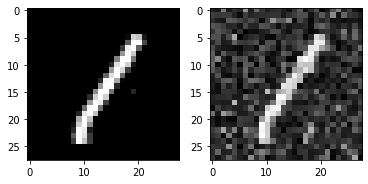

25  :  0.66097028399965 25
50  :  0.66097028399965 25
75  :  0.66097028399965 25
100  :  0.66097028399965 25
125  :  0.6660216009414052 25
150  :  0.6660216009414052 25
175  :  0.6718596337274149 25
200  :  0.6695911600683765 25
225  :  0.6680847585023497 25
250  :  0.6690477945265494 25
275  :  0.6690799850386454 25
300  :  0.6690799850386454 25
325  :  0.6690799850386454 25
350  :  0.6690799850386454 25
375  :  0.669291177800974 25
400  :  0.6690799850386454 25
425  :  0.6690799850386454 25
450  :  0.6692429230370588 25
475  :  0.6700809930133244 25
500  :  0.6705243336734001 25
525  :  0.6704358394226517 25
550  :  0.6719739496722904 25
575  :  0.6720976716907038 25
600  :  0.6725927169070074 25
625  :  0.6762405523246414 25
650  :  0.6758422270230136 25
675  :  0.6758422270230136 25
700  :  0.6766845974983138 25
725  :  0.6766698245020659 25
750  :  0.6766698245020659 25
775  :  0.6773349840722304 25
800  :  0.6770005132505164 25
Time:  66.80301260948181  seconds
Predicted class:  

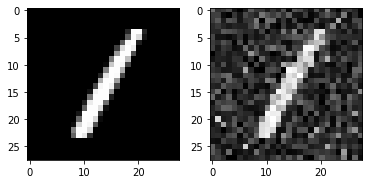

25  :  -0.18412375293746963 25
50  :  -0.17405569484527217 25
75  :  -0.17222203015026266 25
100  :  -0.16970244139373153 25
125  :  -0.16900919968326827 25
150  :  -0.16900919968326827 25
175  :  -0.16509047803630317 25
200  :  -0.16509181348671892 25
225  :  -0.16338909308404015 25
250  :  -0.16012231647149788 25
275  :  -0.16012231647149788 25
300  :  -0.1551433061087542 25
325  :  -0.1551433061087542 25
350  :  -0.1549577664634611 25
375  :  -0.15275339908360563 25
400  :  -0.15236039819487496 25
425  :  -0.1474531428167593 25
450  :  -0.14745695137088083 25
475  :  -0.14734179467941494 25
500  :  -0.14734580499783073 25
525  :  -0.1439921051014904 25
550  :  -0.1439921051014904 25
575  :  -0.1436422706161301 25
600  :  -0.1436422706161301 25
625  :  -0.1435008783598704 25
650  :  -0.14294667570980363 25
675  :  -0.14111379778133082 25
700  :  -0.14111462879228465 25
725  :  -0.14111462879228465 25
750  :  -0.14111462879228465 25
775  :  -0.14070762440842832 25
800  :  -0.140707624

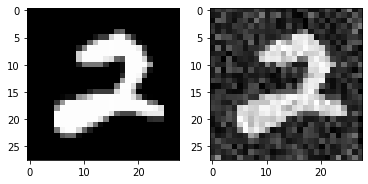

25  :  -0.06909662848327136 25
50  :  -0.06909662848327136 25
75  :  -0.06909662848327136 25
100  :  0.6113017484139149 25
125  :  0.6121520510294768 25
150  :  0.7092749392102832 25
175  :  0.6871972836384732 25
200  :  0.6939238998208787 25
225  :  0.6993457461808823 25
250  :  0.7112950300573759 25
275  :  0.7114907342791443 25
300  :  0.7175828024909252 25
325  :  0.7175828024909252 25
350  :  0.7175828024909252 25
375  :  0.7175828024909252 25
400  :  0.7175828024909252 25
425  :  0.7175828024909252 25
450  :  0.7175828024909252 25
475  :  0.7180066221468824 25
500  :  0.7219852941003146 25
525  :  0.7214784969434128 25
550  :  0.7242477238332697 25
575  :  0.7271510904455752 25
600  :  0.7274975342068266 25
625  :  0.7338703466774652 25
650  :  0.7346386100430445 25
675  :  0.7358889311764931 25
700  :  0.7358889311764931 25
725  :  0.7358889311764931 25
750  :  0.7368377401829713 25
775  :  0.7390907510450979 25
800  :  0.7390935543476798 25
825  :  0.7406978958117012 25
850  : 

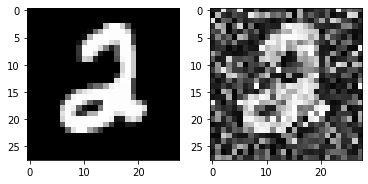

25  :  0.6924769073439 25
50  :  0.6924769073439 25
75  :  0.5905003298066223 25
100  :  0.6206828961863061 25
125  :  0.6840697024206582 25
150  :  0.695710606418148 25
175  :  0.699626389681199 25
200  :  0.699626389681199 25
225  :  0.699626389681199 25
250  :  0.699626389681199 25
275  :  0.699626389681199 25
300  :  0.699626389681199 25
325  :  0.699626389681199 25
350  :  0.7109659343369445 25
375  :  0.7108960073122781 25
400  :  0.7243828517901177 25
425  :  0.724256617339847 25
450  :  0.724256617339847 25
475  :  0.7245997344338041 25
500  :  0.7245997344338041 25
525  :  0.7270604609632179 25
550  :  0.7270604609632179 25
575  :  0.7270604609632179 25
600  :  0.7270604609632179 25
625  :  0.7278036156523466 25
650  :  0.7291957703158366 25
675  :  0.7300907642519234 25
700  :  0.7316501002979621 25
725  :  0.731840932439205 25
750  :  0.7318639996990879 25
775  :  0.7325897828369156 25
800  :  0.7325897828369156 25
825  :  0.7330785500861685 25
850  :  0.733216402940231 25
8

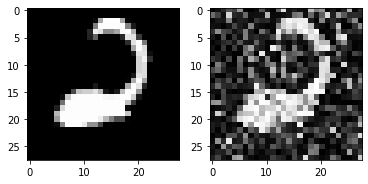

25  :  0.6771290981421191 25
50  :  0.6878685032178483 25
75  :  0.6927475082736465 25
100  :  0.702213103416282 25
125  :  0.703953781890652 25
150  :  0.703953781890652 25
175  :  0.703953781890652 25
200  :  0.7046869823880471 25
225  :  0.7072794408148537 25
250  :  0.7072794408148537 25
275  :  0.7072794408148537 25
300  :  0.7072794408148537 25
325  :  0.7112545292041037 25
350  :  0.713229571620511 25
375  :  0.7148507088690588 25
400  :  0.7158298038059833 25
425  :  0.7183127445872366 25
450  :  0.7182219354649912 25
475  :  0.7196984710907888 25
500  :  0.7197010075118815 25
525  :  0.7221767602997711 25
550  :  0.7227851280282286 25
575  :  0.7245341857584509 25
600  :  0.7250834545897453 25
625  :  0.7250834545897453 25
650  :  0.7259074361565456 25
675  :  0.7275981042803206 25
700  :  0.7275981042803206 25
725  :  0.7284357625177443 25
750  :  0.7284332383401232 25
775  :  0.7284332383401232 25
800  :  0.7293410787364992 25
825  :  0.7293410787364992 25
Time:  70.77204513

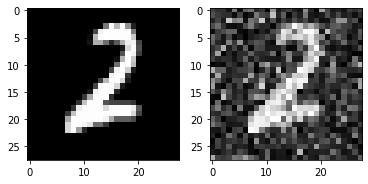

25  :  0.43706238089303895 25
50  :  0.6864176557793523 25
75  :  0.6253857965309053 25
100  :  0.693545486621495 25
125  :  0.693545486621495 25
150  :  0.6999130388453685 25
175  :  0.6999130388453685 25
200  :  0.6999130388453685 25
225  :  0.7011130771140527 25
250  :  0.7013057402016367 25
275  :  0.7013057402016367 25
300  :  0.7013057402016367 25
325  :  0.703276604607638 25
350  :  0.7048115781652862 25
375  :  0.709728744315181 25
400  :  0.709662846320754 25
425  :  0.709662846320754 25
450  :  0.7157158817667053 25
475  :  0.7155156790705002 25
500  :  0.7160233889508822 25
525  :  0.7160233889508822 25
550  :  0.7160233889508822 25
575  :  0.7160233889508822 25
600  :  0.7160233889508822 25
625  :  0.7208868213709925 25
650  :  0.7208868213709925 25
675  :  0.7208868213709925 25
700  :  0.7220351428726204 25
725  :  0.7227124258345348 25
750  :  0.7227124258345348 25
775  :  0.7274998848967507 25
800  :  0.7274998848967507 25
825  :  0.7280989616261628 25
850  :  0.72809896

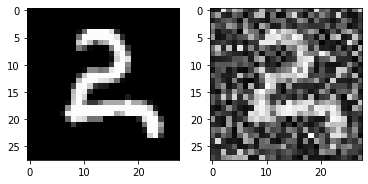

25  :  0.7233464883032703 25
50  :  0.7233464883032703 25
75  :  0.7253063131884042 25
100  :  0.7291301161330344 25
125  :  0.7346597820603924 25
150  :  0.7370122224679005 25
175  :  0.7375723648288134 25
200  :  0.7375723648288134 25
225  :  0.7375723648288134 25
250  :  0.737602635680328 25
275  :  0.7421070514684229 25
300  :  0.7436804855875019 25
325  :  0.7456882818795443 25
350  :  0.7567875450126011 25
375  :  0.7539387501744925 25
400  :  0.7537509532505255 25
425  :  0.7537509532505255 25
450  :  0.7537509532505255 25
475  :  0.7537509532505255 25
500  :  0.7537509532505255 25
525  :  0.7537509532505255 25
550  :  0.7567749690622244 25
575  :  0.75677409900887 25
600  :  0.7577153871782352 25
625  :  0.7577153871782352 25
650  :  0.7583417810111072 25
675  :  0.758763098258487 25
700  :  0.7592679746857198 25
725  :  0.7604306677177103 25
750  :  0.7604306677177103 25
775  :  0.7604388790047678 25
800  :  0.7607152979289544 25
825  :  0.7613823871377972 25
850  :  0.7631632

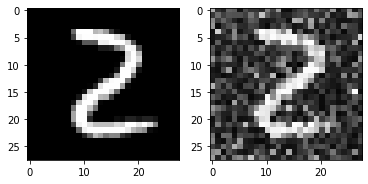

25  :  0.7820549862674502 25
50  :  0.7820549862674502 25
75  :  0.7820549862674502 25
100  :  0.7820549862674502 25
125  :  0.7820549862674502 25
150  :  0.7820549862674502 25
175  :  0.7820549862674502 25
200  :  0.7820549862674502 25
225  :  0.7820549862674502 25
250  :  0.7820549862674502 25
275  :  0.7820549862674502 25
300  :  0.7845050396687707 25
325  :  0.7845050396687707 25
350  :  0.7845050396687707 25
375  :  0.7845050396687707 25
400  :  0.7857070604779476 25
425  :  0.7884486007726506 25
450  :  0.7881687889072246 25
475  :  0.7905952101496707 25
500  :  0.7895866318556554 25
525  :  0.7895866318556554 25
550  :  0.7896962278994772 25
575  :  0.7896962278994772 25
600  :  0.7896962278994772 25
625  :  0.7897317306953393 25
650  :  0.7909218304612979 25
675  :  0.7920512406363527 25
700  :  0.7945153456931985 25
725  :  0.7973489378407819 25
750  :  0.7972041232906795 25
775  :  0.7973324961208723 25
800  :  0.7992383035076367 25
Time:  68.4853162765503  seconds
Predicted 

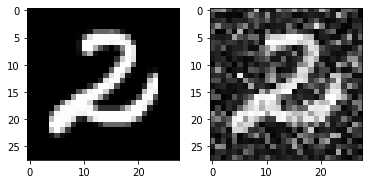

25  :  0.5327083716105336 25
50  :  0.6502533554075398 25
75  :  0.7097844308304249 25
100  :  0.7064961788356436 25
125  :  0.7052790610102584 25
150  :  0.7052790610102584 25
175  :  0.714588885483452 25
200  :  0.7155649588120545 25
225  :  0.717379089182314 25
250  :  0.717379089182314 25
275  :  0.717379089182314 25
300  :  0.717379089182314 25
325  :  0.717379089182314 25
350  :  0.7189320966337706 25
375  :  0.7189320966337706 25
400  :  0.7189320966337706 25
425  :  0.723747498874179 25
450  :  0.723747498874179 25
475  :  0.723747498874179 25
500  :  0.7262435009533574 25
525  :  0.7271061937730909 25
550  :  0.7271156749713071 25
575  :  0.7271061937730909 25
600  :  0.7290547155180842 25
625  :  0.7290251316388211 25
650  :  0.7290251316388211 25
675  :  0.7290251316388211 25
700  :  0.7295206924741477 25
725  :  0.7300044832461802 25
750  :  0.7308661907483197 25
775  :  0.7317656675222789 25
800  :  0.7317421490172145 25
825  :  0.7331229628249223 25
850  :  0.733232626100

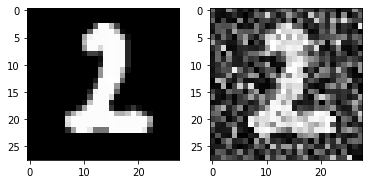

25  :  0.6969559897029056 25
50  :  0.6969559897029056 25
75  :  0.6969559897029056 25
100  :  0.7067270665885061 25
125  :  0.7060986629091781 25
150  :  0.7085737693897669 25
175  :  0.7176094980106009 25
200  :  0.7176094980106009 25
225  :  0.7176094980106009 25
250  :  0.7176094980106009 25
275  :  0.7176094980106009 25
300  :  0.7176094980106009 25
325  :  0.7176094980106009 25
350  :  0.7176094980106009 25
375  :  0.7176876499471675 25
400  :  0.7176094980106009 25
425  :  0.718535722064531 25
450  :  0.7194250706917711 25
475  :  0.7194250706917711 25
500  :  0.7235639015113382 25
525  :  0.7234689450736562 25
550  :  0.7255670452752486 25
575  :  0.7255546056108403 25
600  :  0.7258991574355766 25
625  :  0.7257474693368545 25
650  :  0.7257474693368545 25
675  :  0.7295005461693495 25
700  :  0.7295023815444346 25
725  :  0.7295023815444346 25
750  :  0.7305576734813077 25
775  :  0.7317963369557714 25
800  :  0.7319728502894588 25
Time:  68.61864280700684  seconds
Predicted 

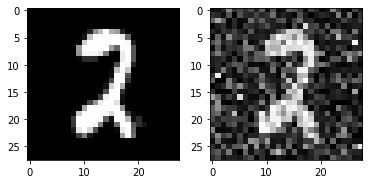

25  :  0.6159861181353776 25
50  :  0.6477598701328717 25
75  :  0.6497208677432491 25
100  :  0.661882761038751 25
125  :  0.6880006047465836 25
150  :  0.6898160567800462 25
175  :  0.6898160567800462 25
200  :  0.6924634606107285 25
225  :  0.6924634606107285 25
250  :  0.6924634606107285 25
275  :  0.6924634606107285 25
300  :  0.6924634606107285 25
325  :  0.6924634606107285 25
350  :  0.6924634606107285 25
375  :  0.6937837282384656 25
400  :  0.6939400412998227 25
425  :  0.6943501446591396 25
450  :  0.6956867654569419 25
475  :  0.6960013619121074 25
500  :  0.7000575937783803 25
525  :  0.7000394821080596 25
550  :  0.7008406730780014 25
575  :  0.7024598332476589 25
600  :  0.7033295124160645 25
625  :  0.703162026965274 25
650  :  0.7034814235144649 25
675  :  0.7037166373631601 25
700  :  0.7042511387180491 25
725  :  0.7046143925130421 25
750  :  0.7067515561013087 25
775  :  0.7067827429572906 25
800  :  0.7076887841691113 25
825  :  0.7076890864560075 25
850  :  0.70819

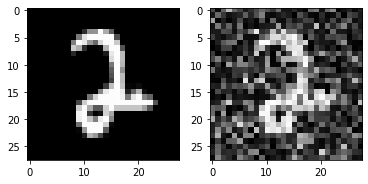

25  :  0.723121948571176 25
50  :  0.723121948571176 25
75  :  0.7461853321704696 25
100  :  0.7479923793507566 25
125  :  0.7479923793507566 25
150  :  0.7479923793507566 25
175  :  0.7479923793507566 25
200  :  0.7479923793507566 25
225  :  0.7479923793507566 25
250  :  0.7479923793507566 25
275  :  0.7479923793507566 25
300  :  0.7479923793507566 25
325  :  0.7479923793507566 25
350  :  0.7479923793507566 25
375  :  0.7479923793507566 25
400  :  0.7479923793507566 25
425  :  0.7489371498969537 25
450  :  0.7518237168493186 25
475  :  0.7600420740487933 25
500  :  0.7600420740487933 25
525  :  0.7600420740487933 25
550  :  0.7601572653227417 25
575  :  0.761545676557541 25
600  :  0.7619477740735634 25
625  :  0.7619477740735634 25
650  :  0.7629139618932337 25
675  :  0.7630628882284625 25
700  :  0.7630385081559979 25
725  :  0.764897167955641 25
750  :  0.764897167955641 25
775  :  0.764897167955641 25
800  :  0.764897167955641 25
825  :  0.764897167955641 25
850  :  0.76508999959

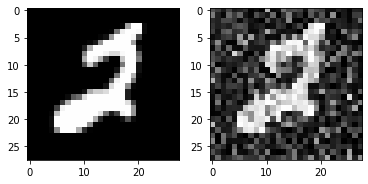

25  :  0.6872926049558082 25
50  :  0.6872926049558082 25
75  :  0.5346546363534646 25
100  :  0.5913255887036939 25
125  :  0.6759559180445156 25
150  :  0.6736302002053564 25
175  :  0.6978800035143418 25
200  :  0.6844791928369043 25
225  :  0.6844791928369043 25
250  :  0.6844791928369043 25
275  :  0.6844791928369043 25
300  :  0.6896453672523756 25
325  :  0.7062862944577109 25
350  :  0.7056411794411207 25
375  :  0.706094256359902 25
400  :  0.706094256359902 25
425  :  0.706094256359902 25
450  :  0.706094256359902 25
475  :  0.706094256359902 25
500  :  0.706094256359902 25
525  :  0.706094256359902 25
550  :  0.7072456830371406 25
575  :  0.7075676117924794 25
600  :  0.7078021999510896 25
625  :  0.7099640815585805 25
650  :  0.7103422014330691 25
675  :  0.7130957339483708 25
700  :  0.7146975746371574 25
725  :  0.7161978504817738 25
750  :  0.7161983238739766 25
775  :  0.7166321857040823 25
800  :  0.7168849141397066 25
825  :  0.7171481687495588 25
850  :  0.7171401233

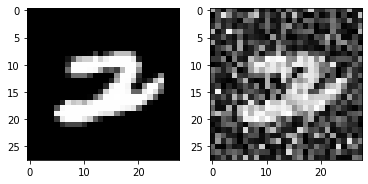

25  :  0.7190112100046121 25
50  :  0.7190112100046121 25
75  :  0.721995957794468 25
100  :  0.7231471276496036 25
125  :  0.7253290549704643 25
150  :  0.7268547606100735 25
175  :  0.7351006190617705 25
200  :  0.7366424832599232 25
225  :  0.7416281131376585 25
250  :  0.7434892612196042 25
275  :  0.7480969483677257 25
300  :  0.7526177346271521 25
325  :  0.7527844008085052 25
350  :  0.7527844008085052 25
375  :  0.7527844008085052 25
400  :  0.7539704487349608 25
425  :  0.7539836368288497 25
450  :  0.7554672163302346 25
475  :  0.7554672163302346 25
500  :  0.7569095687179896 25
525  :  0.7589756235175538 25
550  :  0.7619026082192193 25
575  :  0.7618760845143306 25
600  :  0.7620831356375815 25
625  :  0.7620846961776218 25
650  :  0.7620846961776218 25
675  :  0.7626706741491485 25
700  :  0.7631396657820715 25
725  :  0.7640518809876544 25
750  :  0.7652561807518088 25
775  :  0.7653695431302221 25
800  :  0.7655282643143495 25
Time:  75.5929946899414  seconds
Predicted c

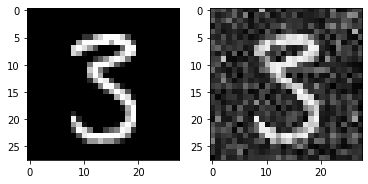

25  :  0.7499816250285475 25
50  :  0.7636675310924255 25
75  :  0.7646756003951672 25
100  :  0.7645769713895976 25
125  :  0.7645769713895976 25
150  :  0.7645769713895976 25
175  :  0.7645769713895976 25
200  :  0.7778934367962964 25
225  :  0.7868337060524551 25
250  :  0.7868337060524551 25
275  :  0.7888118631691178 25
300  :  0.7887947335980185 25
325  :  0.7889939787964779 25
350  :  0.7889939787964779 25
375  :  0.7889939787964779 25
400  :  0.7889939787964779 25
425  :  0.7904001348878495 25
450  :  0.792117295099632 25
475  :  0.7952639840946394 25
500  :  0.7952660044410538 25
525  :  0.7952660044410538 25
550  :  0.7952660044410538 25
575  :  0.795596539262126 25
600  :  0.7971755340046769 25
625  :  0.7971755340046769 25
650  :  0.7974686827043421 25
675  :  0.797622912933025 25
700  :  0.7976517298610948 25
725  :  0.7981038949010526 25
750  :  0.7986280567152686 25
775  :  0.7989733970995252 25
800  :  0.7993857785486785 25
825  :  0.7995167902338094 25
850  :  0.799516

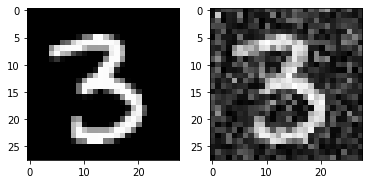

25  :  0.7707359154142441 25
50  :  0.7707359154142441 25
75  :  0.7723829696873106 25
100  :  0.775486885940355 25
125  :  0.775486885940355 25
150  :  0.775486885940355 25
175  :  0.775486885940355 25
200  :  0.775486885940355 25
225  :  0.775486885940355 25
250  :  0.7777140346653968 25
275  :  0.7825717859878575 25
300  :  0.7826529585231989 25
325  :  0.7827606652975327 25
350  :  0.785469118558979 25
375  :  0.785397410184058 25
400  :  0.785397410184058 25
425  :  0.7856125495508949 25
450  :  0.7884262012492901 25
475  :  0.7914394083746495 25
500  :  0.7950249144125521 25
525  :  0.7950368282632061 25
550  :  0.7950368282632061 25
575  :  0.7950368282632061 25
600  :  0.7950368282632061 25
625  :  0.7950368282632061 25
650  :  0.7951943989315181 25
675  :  0.7954866885365811 25
700  :  0.7954945947891596 25
725  :  0.7964761195771657 25
750  :  0.7964661848261662 25
775  :  0.7968918822208897 25
800  :  0.7976533258922419 25
Time:  72.01817965507507  seconds
Predicted class:  

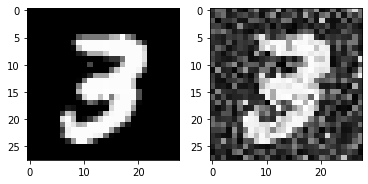

25  :  0.7541559436552461 25
50  :  0.7541559436552461 25
75  :  0.7634850217641429 25
100  :  0.7607412251582322 25
125  :  0.7607412251582322 25
150  :  0.7614523441096434 25
175  :  0.7632231214179568 25
200  :  0.7632231214179568 25
225  :  0.7671666750074322 25
250  :  0.7742983447921932 25
275  :  0.7782225455583243 25
300  :  0.7760416130264165 25
325  :  0.7788937907372274 25
350  :  0.7804904869916298 25
375  :  0.7885270302094796 25
400  :  0.7883817030435483 25
425  :  0.7884150440047009 25
450  :  0.7902967178690523 25
475  :  0.7895302270377348 25
500  :  0.7895302270377348 25
525  :  0.7895302270377348 25
550  :  0.7915343446831566 25
575  :  0.7916122395526386 25
600  :  0.7932626753167249 25
625  :  0.7932950749907284 25
650  :  0.7932950749907284 25
675  :  0.7935374570967426 25
700  :  0.7948991452137095 25
725  :  0.795217644235378 25
750  :  0.7953091437726962 25
775  :  0.7956593086519113 25
800  :  0.7961961873279335 25
Time:  71.5461893081665  seconds
Predicted c

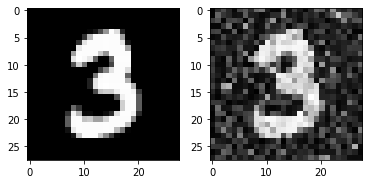

25  :  0.7392301606230334 25
50  :  0.7392301606230334 25
75  :  0.7418780809629258 25
100  :  0.7514467297519263 25
125  :  0.7522457884908962 25
150  :  0.7522457884908962 25
175  :  0.7522457884908962 25
200  :  0.7593376166111119 25
225  :  0.7592113479881053 25
250  :  0.7592113479881053 25
275  :  0.7592113479881053 25
300  :  0.7592113479881053 25
325  :  0.7592113479881053 25
350  :  0.7600308667032923 25
375  :  0.760304647205629 25
400  :  0.7607577042602021 25
425  :  0.7617815514735341 25
450  :  0.7625630245216906 25
475  :  0.7637724469826149 25
500  :  0.7662191015205042 25
525  :  0.7666675108714481 25
550  :  0.7722056138972446 25
575  :  0.7722056138972446 25
600  :  0.7722056138972446 25
625  :  0.7722056138972446 25
650  :  0.7722056138972446 25
675  :  0.7722056138972446 25
700  :  0.7722056138972446 25
725  :  0.7737903643864927 25
750  :  0.775638401334489 25
775  :  0.7762763361732521 25
800  :  0.7762209647131786 25
Time:  73.15388488769531  seconds
Predicted c

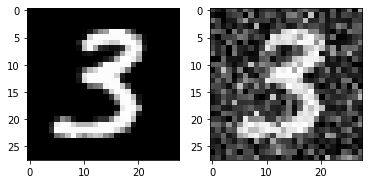

25  :  0.7217868440819095 25
50  :  0.7217868440819095 25
75  :  0.7217868440819095 25
100  :  0.7217868440819095 25
125  :  0.7217868440819095 25
150  :  0.7217868440819095 25
175  :  0.7217868440819095 25
200  :  0.7217868440819095 25
225  :  0.7217868440819095 25
250  :  0.722161236151105 25
275  :  0.722161236151105 25
300  :  0.722161236151105 25
325  :  0.7226776278744151 25
350  :  0.7226776278744151 25
375  :  0.7249448349927614 25
400  :  0.7249448349927614 25
425  :  0.7271824419410186 25
450  :  0.7272314563588224 25
475  :  0.7272314563588224 25
500  :  0.7290880249258045 25
525  :  0.7292430941934822 25
550  :  0.7309306403811309 25
575  :  0.731741170099663 25
600  :  0.7324945713163302 25
625  :  0.7324759745818131 25
650  :  0.7332170073663765 25
675  :  0.7347149751343381 25
700  :  0.7347092809969059 25
725  :  0.734707682416468 25
750  :  0.7354041787391992 25
775  :  0.7363563641224395 25
800  :  0.7364854458532909 25
Time:  73.32497978210449  seconds
Predicted clas

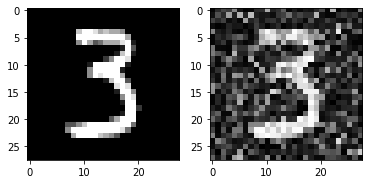

25  :  0.04490411068955116 25
50  :  0.7243845070416657 25
75  :  0.7222221001422309 25
100  :  0.7222221001422309 25
125  :  0.7222221001422309 25
150  :  0.7222221001422309 25
175  :  0.7222221001422309 25
200  :  0.7222221001422309 25
225  :  0.7253430828067846 25
250  :  0.7021452212031554 25
275  :  0.7021452212031554 25
300  :  0.7021452212031554 25
325  :  0.7230290558921717 25
350  :  0.7053128830152509 25
375  :  0.6960819927398426 25
400  :  0.6969574008533785 25
425  :  0.6976576708566724 25
450  :  0.7060892362542207 25
475  :  0.7060892362542207 25
500  :  0.7060892362542207 25
525  :  0.708567595873658 25
550  :  0.7092436462585574 25
575  :  0.7092436462585574 25
600  :  0.7299009558091384 25
625  :  0.7238229287162496 25
650  :  0.724117687420081 25
675  :  0.7238229287162496 25
700  :  0.7238229287162496 25
725  :  0.7238229287162496 25
750  :  0.7238229287162496 25
775  :  0.7313044701180758 25
800  :  0.7316273728846271 25
825  :  0.7313514983974352 25
850  :  0.7328

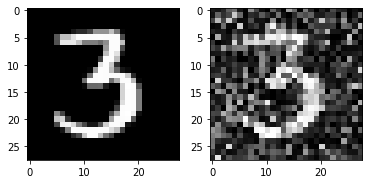

25  :  0.2269675214535604 25
50  :  0.6805172651711965 25
75  :  0.6856304403571265 25
100  :  0.7130405894664363 25
125  :  0.7132060560738084 25
150  :  0.7155362457745786 25
175  :  0.7155362457745786 25
200  :  0.7207945040345548 25
225  :  0.7159932633288884 25
250  :  0.7194896850122933 25
275  :  0.7196906988847783 25
300  :  0.7196906988847783 25
325  :  0.720145360310813 25
350  :  0.7219728190247037 25
375  :  0.7220461366596067 25
400  :  0.7259434701782507 25
425  :  0.7268878108345199 25
450  :  0.7303032499161248 25
475  :  0.7305760036337254 25
500  :  0.736187587517388 25
525  :  0.7351159344274284 25
550  :  0.7360502119390432 25
575  :  0.7359376539886852 25
600  :  0.7385140225735607 25
625  :  0.7385225538489543 25
650  :  0.7398972672235848 25
675  :  0.7397853282068954 25
700  :  0.7397853282068954 25
725  :  0.7401042053184823 25
750  :  0.7399384972802046 25
775  :  0.7399384972802046 25
800  :  0.740391856573231 25
825  :  0.7424490449999158 25
850  :  0.745853

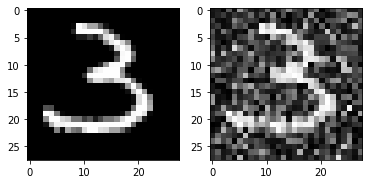

25  :  0.6502511504101032 25
50  :  0.7554064952278305 25
75  :  0.7539698396290841 25
100  :  0.7531686424265807 25
125  :  0.7587678684835026 25
150  :  0.7611130601658913 25
175  :  0.7593478214577791 25
200  :  0.7593478214577791 25
225  :  0.7678681529645013 25
250  :  0.7693585468839326 25
275  :  0.770751855736763 25
300  :  0.7737161603387457 25
325  :  0.7757685444351342 25
350  :  0.775718146467369 25
375  :  0.7790145317466937 25
400  :  0.7790145317466937 25
425  :  0.7790145317466937 25
450  :  0.7790145317466937 25
475  :  0.7790145317466937 25
500  :  0.7822981548797292 25
525  :  0.7822981548797292 25
550  :  0.784173420987275 25
575  :  0.784173420987275 25
600  :  0.7882025221903105 25
625  :  0.7882025221903105 25
650  :  0.7882223600907707 25
675  :  0.7882223600907707 25
700  :  0.7882223600907707 25
725  :  0.7882784898830975 25
750  :  0.7885816991750225 25
775  :  0.7896597957799572 25
800  :  0.7897556533323046 25
825  :  0.7902442958572589 25
Time:  71.0752146

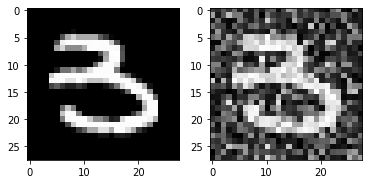

25  :  0.681617633402452 25
50  :  0.6888377495886141 25
75  :  0.6941290009799087 25
100  :  0.6941290009799087 25
125  :  0.6961879232264282 25
150  :  0.7062038671814799 25
175  :  0.7053370373542289 25
200  :  0.7095670129324961 25
225  :  0.710510806730234 25
250  :  0.7103763479467287 25
275  :  0.714026403467003 25
300  :  0.7164705514750588 25
325  :  0.7152731955567462 25
350  :  0.7193715611259905 25
375  :  0.7193249890197754 25
400  :  0.7212814748196286 25
425  :  0.7209707671655115 25
450  :  0.7217036228188679 25
475  :  0.7237773603740815 25
500  :  0.7236197037507748 25
525  :  0.7236197037507748 25
550  :  0.7242085463342253 25
575  :  0.7249683854804219 25
600  :  0.7249683854804219 25
625  :  0.7249683854804219 25
650  :  0.725105971330021 25
675  :  0.726055603610531 25
700  :  0.7264912887604073 25
725  :  0.7273551081284836 25
750  :  0.7273551081284836 25
775  :  0.7278005981387965 25
800  :  0.7283302761790743 25
825  :  0.7288705582635941 25
850  :  0.72940530

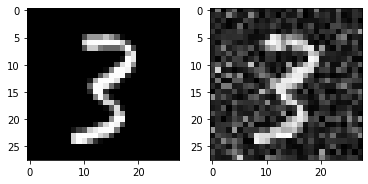

25  :  0.7192668516412899 25
50  :  0.7192668516412899 25
75  :  0.7192668516412899 25
100  :  0.7192668516412899 25
125  :  0.7192668516412899 25
150  :  0.7192668516412899 25
175  :  0.7192668516412899 25
200  :  0.721745265320163 25
225  :  0.721745265320163 25
250  :  0.721745265320163 25
275  :  0.721745265320163 25
300  :  0.721745265320163 25
325  :  0.721745265320163 25
350  :  0.721745265320163 25
375  :  0.7221001389924824 25
400  :  0.7231461953584166 25
425  :  0.7316720257338507 25
450  :  0.7342347222383906 25
475  :  0.7342347222383906 25
500  :  0.7342347222383906 25
525  :  0.7342347222383906 25
550  :  0.7342347222383906 25
575  :  0.7342347222383906 25
600  :  0.7342347222383906 25
625  :  0.7342347222383906 25
650  :  0.7350420113595869 25
675  :  0.7377744816015044 25
700  :  0.7389372627407949 25
725  :  0.7403696856072253 25
750  :  0.7411200366362559 25
775  :  0.742084469994325 25
800  :  0.7420808798240299 25
Time:  68.03886604309082  seconds
Predicted class: 

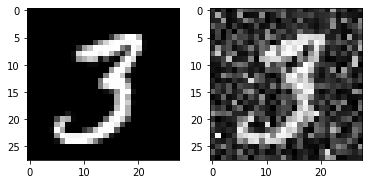

25  :  0.7446048955866008 25
50  :  0.7446048955866008 25
75  :  0.7425859898074896 25
100  :  0.7425859898074896 25
125  :  0.7425859898074896 25
150  :  0.7425859898074896 25
175  :  0.7483792224748723 25
200  :  0.7478022318536 25
225  :  0.7478022318536 25
250  :  0.7478022318536 25
275  :  0.7478022318536 25
300  :  0.7522774205808189 25
325  :  0.752165015992183 25
350  :  0.7524443054838543 25
375  :  0.7528315794833156 25
400  :  0.7528315794833156 25
425  :  0.7550749510389958 25
450  :  0.7586660704819537 25
475  :  0.7586660704819537 25
500  :  0.7586660704819537 25
525  :  0.7586805253987632 25
550  :  0.7594304140732613 25
575  :  0.7607024610107079 25
600  :  0.7607024610107079 25
625  :  0.7624637380509603 25
650  :  0.7642820658236524 25
675  :  0.7642820658236524 25
700  :  0.7642820658236524 25
725  :  0.764463661143698 25
750  :  0.764685341566441 25
775  :  0.764685341566441 25
800  :  0.7656697239995156 25
Time:  68.71495461463928  seconds
Predicted class:  [8]


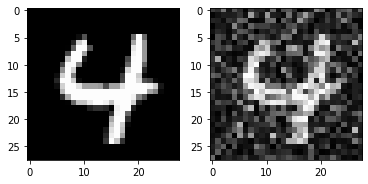

25  :  0.7441929819824433 25
50  :  0.7441929819824433 25
75  :  0.7432929455730709 25
100  :  0.7526630129147187 25
125  :  0.7526630129147187 25
150  :  0.7575332715655161 25
175  :  0.7584172605927404 25
200  :  0.7626668184976463 25
225  :  0.7675960715716019 25
250  :  0.7663960403780656 25
275  :  0.7663960403780656 25
300  :  0.7663960403780656 25
325  :  0.7663960403780656 25
350  :  0.7663960403780656 25
375  :  0.7663960403780656 25
400  :  0.7663960403780656 25
425  :  0.7674385288723333 25
450  :  0.7710689588070305 25
475  :  0.7734043632003471 25
500  :  0.7733675776470126 25
525  :  0.7785601459968133 25
550  :  0.7786042199115567 25
575  :  0.7785775560850781 25
600  :  0.779748748366538 25
625  :  0.7798538987748489 25
650  :  0.7806583604411488 25
675  :  0.783970749668369 25
700  :  0.7854188625803964 25
725  :  0.7878028541284405 25
750  :  0.7878028562263033 25
775  :  0.7878028562263033 25
800  :  0.7879013844894588 25
Time:  72.18983769416809  seconds
Predicted c

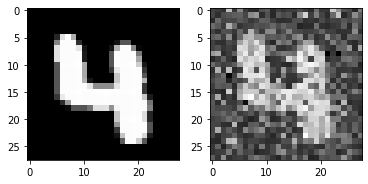

25  :  0.11877010149438605 25
50  :  0.11877010149438605 25
75  :  -0.18156359517082232 25
100  :  0.07677970162401687 25
125  :  -0.09570303859703796 25
150  :  0.582033263986572 25
175  :  0.6584572705179239 25
200  :  0.6904435561729243 25
225  :  0.6906109918048637 25
250  :  0.6883819523013627 25
275  :  0.6883819523013627 25
300  :  0.6883819523013627 25
325  :  0.6938423558693971 25
350  :  0.6930551595768961 25
375  :  0.6930551595768961 25
400  :  0.6983131428752968 25
425  :  0.6998699789995066 25
450  :  0.6998699789995066 25
475  :  0.6998699789995066 25
500  :  0.7019545805433068 25
525  :  0.702511504035323 25
550  :  0.702511504035323 25
575  :  0.7033816498059136 25
600  :  0.7033816498059136 25
625  :  0.70482825780769 25
650  :  0.7080163499360432 25
675  :  0.7080163499360432 25
700  :  0.7080644079107289 25
725  :  0.7141593206596349 25
750  :  0.7141593206596349 25
775  :  0.7141593206596349 25
800  :  0.7141593206596349 25
825  :  0.7159600735672367 25
850  :  0.7

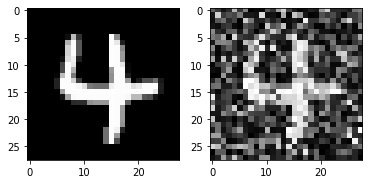

25  :  0.655070507781892 25
50  :  0.6690442648936877 25
75  :  0.6741931954220223 25
100  :  0.6741931954220223 25
125  :  0.6741931954220223 25
150  :  0.6741931954220223 25
175  :  0.6854571177277969 25
200  :  0.6894675251142397 25
225  :  0.6941399432007836 25
250  :  0.6941399432007836 25
275  :  0.6941399432007836 25
300  :  0.6941399432007836 25
325  :  0.6941399432007836 25
350  :  0.6941399432007836 25
375  :  0.6941399432007836 25
400  :  0.6941399432007836 25
425  :  0.6951541138921582 25
450  :  0.6988938421138295 25
475  :  0.6988938421138295 25
500  :  0.7023783265188335 25
525  :  0.7022647880951438 25
550  :  0.7029845678716256 25
575  :  0.7031193955976943 25
600  :  0.7037803745799204 25
625  :  0.7037797792034337 25
650  :  0.7037797792034337 25
675  :  0.7037797792034337 25
700  :  0.7049172773732497 25
725  :  0.7052760744193891 25
750  :  0.7062231872801539 25
775  :  0.7065000398382358 25
800  :  0.7069333112050723 25
825  :  0.7074913901612246 25
850  :  0.7081

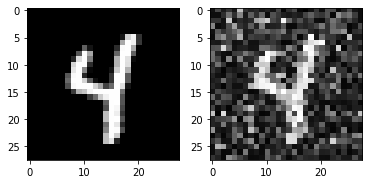

25  :  0.6165353778007066 25
50  :  0.6663003094619904 25
75  :  0.6636790338200881 25
100  :  0.6636790338200881 25
125  :  0.6636790338200881 25
150  :  0.6636790338200881 25
175  :  0.6636790338200881 25
200  :  0.6636790338200881 25
225  :  0.6636790338200881 25
250  :  0.6657682922523912 25
275  :  0.6654846820013975 25
300  :  0.6673356719533421 25
325  :  0.6725563234247202 25
350  :  0.6730982976096995 25
375  :  0.6803948861001295 25
400  :  0.6805203143175403 25
425  :  0.6805203143175403 25
450  :  0.6825543720676079 25
475  :  0.6822679025723709 25
500  :  0.6822679025723709 25
525  :  0.6827659788769359 25
550  :  0.6837636913262276 25
575  :  0.6836212897175115 25
600  :  0.6868432064655673 25
625  :  0.6889020758878591 25
650  :  0.6889855412027146 25
675  :  0.6889855412027146 25
700  :  0.6906539389032265 25
725  :  0.6906200593123888 25
750  :  0.6906200593123888 25
775  :  0.6906200593123888 25
800  :  0.6906200593123888 25
825  :  0.6914601490009974 25
Time:  71.424

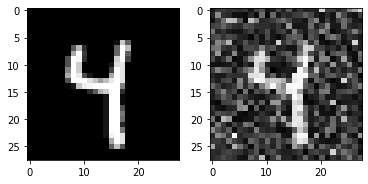

25  :  0.6826176631338797 25
50  :  0.6826176631338797 25
75  :  0.6830312007725027 25
100  :  0.6830312007725027 25
125  :  0.6830312007725027 25
150  :  0.6945676726628474 25
175  :  0.6942782467785821 25
200  :  0.6942782467785821 25
225  :  0.6942782467785821 25
250  :  0.6959851160695845 25
275  :  0.6959851160695845 25
300  :  0.6961667972235164 25
325  :  0.7008990324748128 25
350  :  0.7002599986761504 25
375  :  0.7043812331945299 25
400  :  0.7043812331945299 25
425  :  0.7043812331945299 25
450  :  0.7043812331945299 25
475  :  0.7072342166650251 25
500  :  0.7072342166650251 25
525  :  0.7072342166650251 25
550  :  0.7073643872747476 25
575  :  0.7077529681788238 25
600  :  0.7087444917959814 25
625  :  0.7092329489133029 25
650  :  0.7092329489133029 25
675  :  0.7095604469271743 25
700  :  0.7095604469271743 25
725  :  0.7104123606701325 25
750  :  0.7115448754098698 25
775  :  0.7117558919588121 25
800  :  0.7124241495823134 25
825  :  0.712886654395029 25
850  :  0.7128

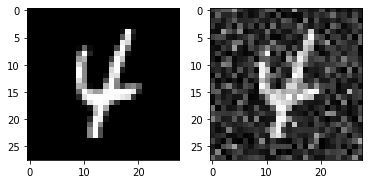

25  :  0.6951574413351471 25
50  :  0.6951574413351471 25
75  :  0.7130458627527589 25
100  :  0.7130458627527589 25
125  :  0.7130458627527589 25
150  :  0.7130458627527589 25
175  :  0.7130458627527589 25
200  :  0.7130458627527589 25
225  :  0.7130458627527589 25
250  :  0.7150223257501748 25
275  :  0.7158695579909173 25
300  :  0.7158695579909173 25
325  :  0.7158695579909173 25
350  :  0.7172253606778576 25
375  :  0.7218168939624011 25
400  :  0.7231676887949965 25
425  :  0.7274957014408792 25
450  :  0.7275290397562794 25
475  :  0.7275290397562794 25
500  :  0.7275290397562794 25
525  :  0.7275290397562794 25
550  :  0.7291556030575412 25
575  :  0.730196841780256 25
600  :  0.7308976035501562 25
625  :  0.7308830540360572 25
650  :  0.7308830540360572 25
675  :  0.7308830540360572 25
700  :  0.7328058717407072 25
725  :  0.7327895563080777 25
750  :  0.7327895563080777 25
775  :  0.7338182683487606 25
800  :  0.7340407276820506 25
825  :  0.7356762338024019 25
850  :  0.7361

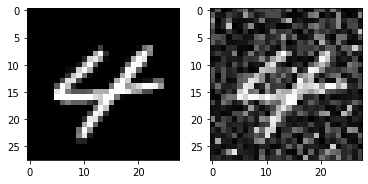

25  :  0.7008873370713933 25
50  :  0.7008873370713933 25
75  :  0.6409761495083288 25
100  :  0.6970840362063516 25
125  :  0.7035050282077909 25
150  :  0.7035050282077909 25
175  :  0.7035050282077909 25
200  :  0.7047967803642422 25
225  :  0.7087479856216231 25
250  :  0.7081519293008529 25
275  :  0.7081264763864829 25
300  :  0.7106708162898583 25
325  :  0.7105126608671565 25
350  :  0.7123063867805439 25
375  :  0.7187449168814517 25
400  :  0.7186387405372202 25
425  :  0.7190802741216192 25
450  :  0.7188834025143502 25
475  :  0.7228808240348068 25
500  :  0.7228808240348068 25
525  :  0.7228808240348068 25
550  :  0.7248755286268118 25
575  :  0.7248755286268118 25
600  :  0.7258243707050305 25
625  :  0.7274854842484076 25
650  :  0.7280375019735399 25
675  :  0.7280375019735399 25
700  :  0.7296130072213527 25
725  :  0.7296109397391746 25
750  :  0.7296109397391746 25
775  :  0.7296109397391746 25
800  :  0.7302596242312993 25
825  :  0.7310389351386881 25
850  :  0.731

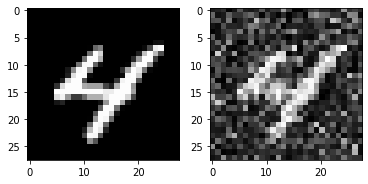

25  :  0.6631074527618265 25
50  :  0.6631074527618265 25
75  :  0.680654051302157 25
100  :  0.6790061776222791 25
125  :  0.6790061776222791 25
150  :  0.6809731827165391 25
175  :  0.6809731827165391 25
200  :  0.6809731827165391 25
225  :  0.6831910285699985 25
250  :  0.6831898629517673 25
275  :  0.6840271470111501 25
300  :  0.6916175372814061 25
325  :  0.6916175372814061 25
350  :  0.6936139621324086 25
375  :  0.6950443582910018 25
400  :  0.7012658523134236 25
425  :  0.7012658523134236 25
450  :  0.7012658523134236 25
475  :  0.7012658523134236 25
500  :  0.7022172509527232 25
525  :  0.7026519955652675 25
550  :  0.7056505475174254 25
575  :  0.7055335993586465 25
600  :  0.706217451434503 25
625  :  0.7062115025335008 25
650  :  0.7062260402962284 25
675  :  0.7062115025335008 25
700  :  0.7075730325666956 25
725  :  0.7084518331516827 25
750  :  0.7083230363771733 25
775  :  0.7087689347582979 25
800  :  0.7090908519725616 25
825  :  0.7093670856245711 25
850  :  0.70943

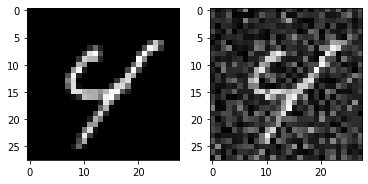

25  :  0.24104333607318695 25
50  :  0.5893394629999065 25
75  :  0.6467356002885088 25
100  :  0.6637346288982519 25
125  :  0.676880864565773 25
150  :  0.676609758853793 25
175  :  0.6660656871181867 25
200  :  0.6820284988464074 25
225  :  0.6820284988464074 25
250  :  0.6820284988464074 25
275  :  0.6820284988464074 25
300  :  0.6824499306119873 25
325  :  0.6851400167995212 25
350  :  0.6851400167995212 25
375  :  0.6851400167995212 25
400  :  0.6853793304016145 25
425  :  0.6906126596330159 25
450  :  0.6906126596330159 25
475  :  0.6906126596330159 25
500  :  0.6906126596330159 25
525  :  0.6906126596330159 25
550  :  0.6909982900504378 25
575  :  0.6913808462816246 25
600  :  0.6928741979710573 25
625  :  0.697558632124956 25
650  :  0.6975047045405991 25
675  :  0.6974583166653534 25
700  :  0.6974813802644174 25
725  :  0.6979525368028732 25
750  :  0.6995137707053362 25
775  :  0.6995137707053362 25
800  :  0.7001724474777314 25
825  :  0.7014886293644449 25
850  :  0.70165

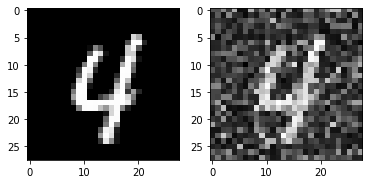

25  :  0.5672402314380129 25
50  :  0.6718736232124188 25
75  :  0.672512813486182 25
100  :  0.6828872427621994 25
125  :  0.6828872427621994 25
150  :  0.6828872427621994 25
175  :  0.6828872427621994 25
200  :  0.6831507270982305 25
225  :  0.682552849183111 25
250  :  0.682552849183111 25
275  :  0.682552849183111 25
300  :  0.6863209229989906 25
325  :  0.6852637635478396 25
350  :  0.6852637635478396 25
375  :  0.6852637635478396 25
400  :  0.6852637635478396 25
425  :  0.6891224595394867 25
450  :  0.6875990005558147 25
475  :  0.6875990005558147 25
500  :  0.6889761782702454 25
525  :  0.6902864896940719 25
550  :  0.6920715765351922 25
575  :  0.6912033428755867 25
600  :  0.6950401684001526 25
625  :  0.6965333891959363 25
650  :  0.6990895222050106 25
675  :  0.6987236010797359 25
700  :  0.6987236010797359 25
725  :  0.702150688016866 25
750  :  0.7021427335871766 25
775  :  0.7027035792452841 25
800  :  0.7027035792452841 25
825  :  0.7027035792452841 25
850  :  0.70292894

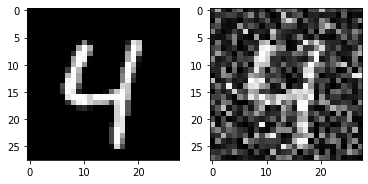

25  :  0.6507947544754502 25
50  :  0.6507947544754502 25
75  :  0.663058649290242 25
100  :  0.663058649290242 25
125  :  0.663058649290242 25
150  :  0.6638163664752261 25
175  :  0.663058649290242 25
200  :  0.663058649290242 25
225  :  0.663058649290242 25
250  :  0.663058649290242 25
275  :  0.663058649290242 25
300  :  0.6733021014843444 25
325  :  0.6720193824321599 25
350  :  0.6720193824321599 25
375  :  0.6720193824321599 25
400  :  0.6731650239274651 25
425  :  0.6789013518989191 25
450  :  0.6780134685591881 25
475  :  0.6784728912059205 25
500  :  0.6792214397406454 25
525  :  0.6790207251164543 25
550  :  0.6802097041189072 25
575  :  0.6827563608790268 25
600  :  0.6827563608790268 25
625  :  0.6827563608790268 25
650  :  0.684415328018319 25
675  :  0.6845258325985819 25
700  :  0.6848165767658625 25
725  :  0.685310736679656 25
750  :  0.6855936221611921 25
775  :  0.6856323995323401 25
800  :  0.6856224687168595 25
825  :  0.6866935823452298 25
850  :  0.6866935823452

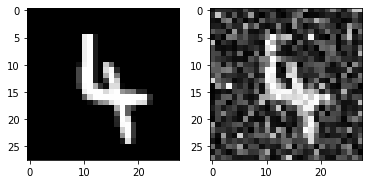

25  :  0.6268924238504343 25
50  :  0.6328063205312525 25
75  :  0.6449062378048123 25
100  :  0.6451484837536479 25
125  :  0.6477282056487315 25
150  :  0.6477282056487315 25
175  :  0.6477282056487315 25
200  :  0.6482126264788831 25
225  :  0.6482126264788831 25
250  :  0.6482126264788831 25
275  :  0.6502850601848218 25
300  :  0.6517392665168596 25
325  :  0.6531936549337158 25
350  :  0.6560033629827854 25
375  :  0.6557353759946054 25
400  :  0.6601146346971822 25
425  :  0.6601146346971822 25
450  :  0.6601146346971822 25
475  :  0.6601146346971822 25
500  :  0.6601146346971822 25
525  :  0.6601146346971822 25
550  :  0.6601146346971822 25
575  :  0.6611653774221996 25
600  :  0.6626916192094123 25
625  :  0.6625752928338594 25
650  :  0.6638289294933398 25
675  :  0.6638289294933398 25
700  :  0.6643919567578068 25
725  :  0.6643942521577613 25
750  :  0.6655397303589881 25
775  :  0.6664037468284373 25
800  :  0.6664027931541209 25
825  :  0.6674051956807285 25
850  :  0.667

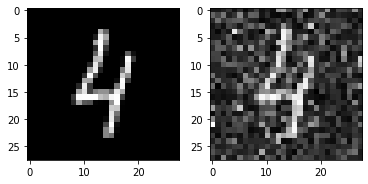

25  :  0.6586584038370207 25
50  :  0.6586584038370207 25
75  :  0.6627577666202771 25
100  :  0.6627577666202771 25
125  :  0.6627577666202771 25
150  :  0.6629439327348566 25
175  :  0.6681005682794252 25
200  :  0.669080664070647 25
225  :  0.6670334850064772 25
250  :  0.6670334850064772 25
275  :  0.6670334850064772 25
300  :  0.6670334850064772 25
325  :  0.6670334850064772 25
350  :  0.6686871730305461 25
375  :  0.6671221632595798 25
400  :  0.6690004219732856 25
425  :  0.6687329392034214 25
450  :  0.6699560668722098 25
475  :  0.6711330830363408 25
500  :  0.674589138807538 25
525  :  0.6744818836373766 25
550  :  0.6758089402138753 25
575  :  0.6757989898405464 25
600  :  0.6771829649711537 25
625  :  0.6786514592177373 25
650  :  0.6786514592177373 25
675  :  0.6786514592177373 25
700  :  0.6791447212292758 25
725  :  0.681812257146091 25
750  :  0.6836473108015652 25
775  :  0.6835667720773329 25
800  :  0.6845057346588089 25
Time:  70.61307692527771  seconds
Predicted cl

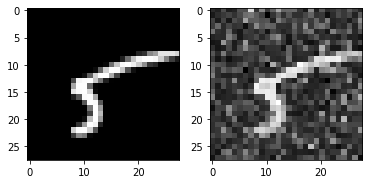

25  :  0.6417631944728103 25
50  :  0.6544539093868513 25
75  :  0.6615936503941757 25
100  :  0.6615936503941757 25
125  :  0.6620808884096818 25
150  :  0.6619946827457793 25
175  :  0.6627055371786486 25
200  :  0.6627055371786486 25
225  :  0.6627055371786486 25
250  :  0.670643920533647 25
275  :  0.670643920533647 25
300  :  0.670643920533647 25
325  :  0.670643920533647 25
350  :  0.670643920533647 25
375  :  0.670643920533647 25
400  :  0.6730984251216681 25
425  :  0.6732255997543175 25
450  :  0.6732255997543175 25
475  :  0.6732255997543175 25
500  :  0.6732255997543175 25
525  :  0.6732255997543175 25
550  :  0.6783306713046617 25
575  :  0.6808244572705648 25
600  :  0.681035897523307 25
625  :  0.6812344597153933 25
650  :  0.6813895398216745 25
675  :  0.6835020613700022 25
700  :  0.6853547865481809 25
725  :  0.6853547865481809 25
750  :  0.6853547865481809 25
775  :  0.6862641851645073 25
800  :  0.6866069109414354 25
825  :  0.6884168633096855 25
Time:  71.5578522682

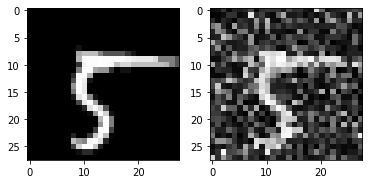

25  :  0.7836069998341056 25
50  :  0.7836069998341056 25
75  :  0.7865733571148854 25
100  :  0.7865733571148854 25
125  :  0.7892400886928226 25
150  :  0.7911410594244763 25
175  :  0.7911410594244763 25
200  :  0.7911410594244763 25
225  :  0.7911410594244763 25
250  :  0.7969710799427088 25
275  :  0.7965345334746468 25
300  :  0.7965345334746468 25
325  :  0.7965345334746468 25
350  :  0.8073483896344631 25
375  :  0.8070737761873097 25
400  :  0.8092281397748315 25
425  :  0.8089680899259004 25
450  :  0.8089680899259004 25
475  :  0.8089680899259004 25
500  :  0.8089680899259004 25
525  :  0.8089680899259004 25
550  :  0.8104444642406647 25
575  :  0.8104444642406647 25
600  :  0.810459524863383 25
625  :  0.8115761396657624 25
650  :  0.811575826067179 25
675  :  0.811575826067179 25
700  :  0.811575826067179 25
725  :  0.8116681630078937 25
750  :  0.8116140641111885 25
775  :  0.813002042242701 25
800  :  0.8129378693622208 25
825  :  0.8137099689263524 25
850  :  0.81464797

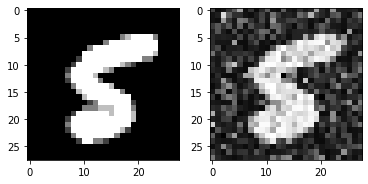

25  :  0.7422701979142212 25
50  :  0.7481501738521809 25
75  :  0.7753327210349056 25
100  :  0.7753327210349056 25
125  :  0.7753327210349056 25
150  :  0.7753327210349056 25
175  :  0.7753327210349056 25
200  :  0.7753327210349056 25
225  :  0.7753327210349056 25
250  :  0.7753327210349056 25
275  :  0.7753327210349056 25
300  :  0.7773962296871331 25
325  :  0.7828282123437635 25
350  :  0.7838773318920698 25
375  :  0.7838773318920698 25
400  :  0.7838773318920698 25
425  :  0.7838773318920698 25
450  :  0.7840295544228301 25
475  :  0.7840818024614813 25
500  :  0.7857641869384013 25
525  :  0.7870709076117186 25
550  :  0.7887264516487044 25
575  :  0.788655212110583 25
600  :  0.788655212110583 25
625  :  0.7896193327697418 25
650  :  0.7898287592657518 25
675  :  0.7916961297164877 25
700  :  0.7929842711728964 25
725  :  0.7939741983115933 25
750  :  0.7948477267316696 25
775  :  0.7956994781350918 25
800  :  0.7973097362186972 25
825  :  0.7971821387114228 25
850  :  0.79797

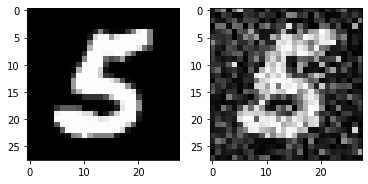

25  :  0.735622298254487 25
50  :  0.7511678538008131 25
75  :  0.7377154506224091 25
100  :  0.7377154506224091 25
125  :  0.7452616929491538 25
150  :  0.7452616929491538 25
175  :  0.7452616929491538 25
200  :  0.7482978376943131 25
225  :  0.7477086807236567 25
250  :  0.7517229733464696 25
275  :  0.7517229733464696 25
300  :  0.7562997379950533 25
325  :  0.7626680121725564 25
350  :  0.7632338023111216 25
375  :  0.7631697138495538 25
400  :  0.7631697138495538 25
425  :  0.7631697138495538 25
450  :  0.7631697138495538 25
475  :  0.7631697138495538 25
500  :  0.7664833997339247 25
525  :  0.7664833997339247 25
550  :  0.7670353248906845 25
575  :  0.7688762554903277 25
600  :  0.7690366004577016 25
625  :  0.7690366004577016 25
650  :  0.7690366004577016 25
675  :  0.7713235388550636 25
700  :  0.7713194119618675 25
725  :  0.7713194119618675 25
750  :  0.7713194119618675 25
775  :  0.7728294500838505 25
800  :  0.7747393239903381 25
825  :  0.7747393239903381 25
850  :  0.7769

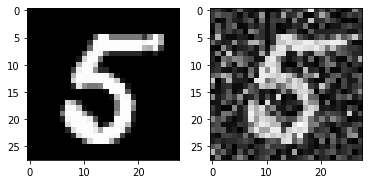

25  :  0.7224410849903865 25
50  :  0.7224410849903865 25
75  :  0.72443908661428 25
100  :  0.7168291964452975 25
125  :  0.7212138574872513 25
150  :  0.7212138574872513 25
175  :  0.7304321125202538 25
200  :  0.728750939331128 25
225  :  0.728750939331128 25
250  :  0.728750939331128 25
275  :  0.728750939331128 25
300  :  0.728750939331128 25
325  :  0.7322487140676808 25
350  :  0.7303677888592381 25
375  :  0.7362509309300248 25
400  :  0.7380924380135425 25
425  :  0.7373062910124809 25
450  :  0.7373062910124809 25
475  :  0.7373062910124809 25
500  :  0.7373062910124809 25
525  :  0.7384800186236452 25
550  :  0.7382878859660686 25
575  :  0.7397302342368365 25
600  :  0.7423393824206391 25
625  :  0.74762416425165 25
650  :  0.747526516922702 25
675  :  0.7517898610082954 25
700  :  0.7514161725314166 25
725  :  0.7514161725314166 25
750  :  0.7540727678772359 25
775  :  0.7540215656690019 25
800  :  0.7540215656690019 25
Time:  70.9193000793457  seconds
Predicted class:  [8

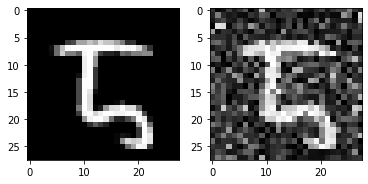

25  :  0.7236827603796329 25
50  :  0.7296352834127646 25
75  :  0.7293967438429351 25
100  :  0.7293967438429351 25
125  :  0.7322100344458002 25
150  :  0.7322100344458002 25
175  :  0.7364238918691162 25
200  :  0.7364238918691162 25
225  :  0.7364238918691162 25
250  :  0.7419835012659783 25
275  :  0.7432967528103609 25
300  :  0.7432967528103609 25
325  :  0.7432967528103609 25
350  :  0.7432967528103609 25
375  :  0.7433724236410637 25
400  :  0.745561409376258 25
425  :  0.745561409376258 25
450  :  0.745561409376258 25
475  :  0.7457366065180977 25
500  :  0.7455783525940713 25
525  :  0.7455819857866638 25
550  :  0.7467516739546235 25
575  :  0.7471822939755532 25
600  :  0.7473655001890536 25
625  :  0.7491235143610386 25
650  :  0.7493572306907034 25
675  :  0.750446849070405 25
700  :  0.7509297804486799 25
725  :  0.7509297804486799 25
750  :  0.751546030221345 25
775  :  0.7515683554893059 25
800  :  0.7519533465462493 25
Time:  72.15722298622131  seconds
Predicted clas

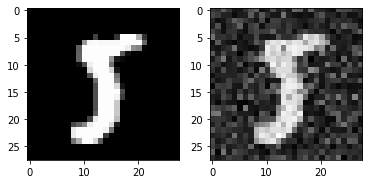

25  :  0.6721205999780021 25
50  :  0.6721205999780021 25
75  :  0.6744333773266336 25
100  :  0.6744333773266336 25
125  :  0.6744333773266336 25
150  :  0.6793338979599146 25
175  :  0.6793211577917615 25
200  :  0.6807077025524825 25
225  :  0.6807077025524825 25
250  :  0.6878298705272858 25
275  :  0.6875903848423115 25
300  :  0.689022914109079 25
325  :  0.6889981400465677 25
350  :  0.6895800291910263 25
375  :  0.6902715914133487 25
400  :  0.691761566481802 25
425  :  0.6941240170620598 25
450  :  0.6941063713678557 25
475  :  0.6941063713678557 25
500  :  0.6957757199358053 25
525  :  0.6957757199358053 25
550  :  0.6957757199358053 25
575  :  0.6977197757034349 25
600  :  0.6977192020649374 25
625  :  0.6977192020649374 25
650  :  0.6987406842477084 25
675  :  0.6987406842477084 25
700  :  0.6987406842477084 25
725  :  0.6999124297314658 25
750  :  0.7008732839918265 25
775  :  0.7010670323542427 25
800  :  0.7010663856015993 25
Time:  70.71817135810852  seconds
Predicted c

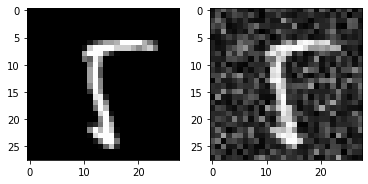

25  :  0.7248045885612793 25
50  :  0.7248045885612793 25
75  :  0.7355820873106952 25
100  :  0.7376342453912894 25
125  :  0.7376342453912894 25
150  :  0.7376342453912894 25
175  :  0.7402736721715142 25
200  :  0.7402736721715142 25
225  :  0.7415835274748693 25
250  :  0.7441559349650763 25
275  :  0.7436951427290985 25
300  :  0.7438027083270538 25
325  :  0.7475274461291634 25
350  :  0.7475274461291634 25
375  :  0.7475274461291634 25
400  :  0.7481051260662307 25
425  :  0.7496885676034752 25
450  :  0.750382176473352 25
475  :  0.750382176473352 25
500  :  0.7517705454456273 25
525  :  0.7532361601674581 25
550  :  0.7538392025684919 25
575  :  0.7551536433450543 25
600  :  0.7561012903194709 25
625  :  0.7590616093620557 25
650  :  0.7586787495547127 25
675  :  0.758716424928358 25
700  :  0.7598984577277001 25
725  :  0.7598990238961474 25
750  :  0.7604025854361349 25
775  :  0.7609263337515759 25
800  :  0.7608885850218323 25
825  :  0.7614770350584451 25
850  :  0.761449

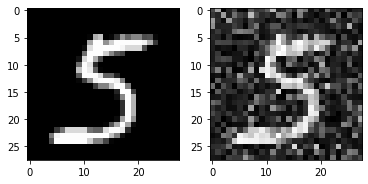

25  :  0.7655899868641107 25
50  :  0.7676935441006258 25
75  :  0.7681367454985273 25
100  :  0.7722362072841531 25
125  :  0.7722362072841531 25
150  :  0.7723549496005057 25
175  :  0.7758032088234899 25
200  :  0.7782188038808365 25
225  :  0.7786622836783916 25
250  :  0.7789709687106514 25
275  :  0.7793850173251274 25
300  :  0.7832091735663088 25
325  :  0.784381520639161 25
350  :  0.7891202818638339 25
375  :  0.7899493605948957 25
400  :  0.7899493605948957 25
425  :  0.7899493605948957 25
450  :  0.7899493605948957 25
475  :  0.7899493605948957 25
500  :  0.7908040274716799 25
525  :  0.7914633761695404 25
550  :  0.7923324505384737 25
575  :  0.7930222012165644 25
600  :  0.7932880485352088 25
625  :  0.7930222012165644 25
650  :  0.7930222012165644 25
675  :  0.7956247009902818 25
700  :  0.7960778074884739 25
725  :  0.7976366749478958 25
750  :  0.7976479641971806 25
775  :  0.7976479641971806 25
800  :  0.7976479641971806 25
Time:  70.17870140075684  seconds
Predicted 

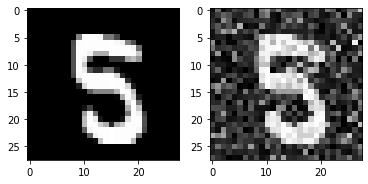

25  :  0.6674617573942296 25
50  :  0.6674617573942296 25
75  :  0.6645516374143744 25
100  :  0.6687417361633388 25
125  :  0.6687417361633388 25
150  :  0.6687417361633388 25
175  :  0.6687417361633388 25
200  :  0.6687417361633388 25
225  :  0.6722203109043672 25
250  :  0.6758020360525346 25
275  :  0.6762250686107734 25
300  :  0.6762250686107734 25
325  :  0.6777813571229393 25
350  :  0.678836908615001 25
375  :  0.6795462542287958 25
400  :  0.682206853490967 25
425  :  0.6833429297291713 25
450  :  0.6833390728633191 25
475  :  0.6833390728633191 25
500  :  0.6833390728633191 25
525  :  0.6833735788951703 25
550  :  0.6836270970684021 25
575  :  0.684042211733681 25
600  :  0.6840423249379305 25
625  :  0.6840423249379305 25
650  :  0.6843324752928321 25
675  :  0.685597443052613 25
700  :  0.6866208471356041 25
725  :  0.6866208471356041 25
750  :  0.6866208471356041 25
775  :  0.6873815070722274 25
800  :  0.6873815070722274 25
Time:  71.08157682418823  seconds
Predicted cla

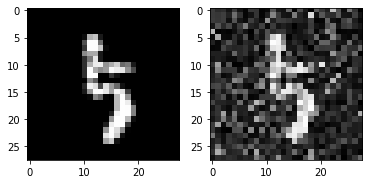

25  :  0.7231242691785144 25
50  :  0.7299317817284505 25
75  :  0.7322899375478359 25
100  :  0.7322899375478359 25
125  :  0.7322899375478359 25
150  :  0.7322899375478359 25
175  :  0.7339026903798529 25
200  :  0.7340995503347013 25
225  :  0.7340995503347013 25
250  :  0.7370132481721826 25
275  :  0.7370132481721826 25
300  :  0.7391410394449243 25
325  :  0.7407505668077986 25
350  :  0.7406751026984145 25
375  :  0.7427085559813345 25
400  :  0.7430170948184687 25
425  :  0.7443585089531539 25
450  :  0.7451248122904459 25
475  :  0.745112376020784 25
500  :  0.7465563077876427 25
525  :  0.7466418128190899 25
550  :  0.7466418128190899 25
575  :  0.7481380147501162 25
600  :  0.748747193980646 25
625  :  0.7500755844970698 25
650  :  0.7500755844970698 25
675  :  0.7510199771212791 25
700  :  0.7510199771212791 25
725  :  0.7513252318349999 25
750  :  0.751517968414567 25
775  :  0.7519079341109252 25
800  :  0.7519079341109252 25
Time:  72.2943742275238  seconds
Predicted cla

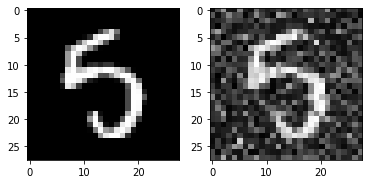

25  :  0.803384981524495 25
50  :  0.803384981524495 25
75  :  0.8028667207411868 25
100  :  0.8028667207411868 25
125  :  0.8037054383922417 25
150  :  0.8037054383922417 25
175  :  0.8104296899322813 25
200  :  0.8107981786057012 25
225  :  0.8164834042563353 25
250  :  0.8185921030405425 25
275  :  0.8179745040760795 25
300  :  0.8206321599616158 25
325  :  0.8228331041089365 25
350  :  0.8227588258218375 25
375  :  0.8233181571117769 25
400  :  0.8262895977573074 25
425  :  0.8262324930411753 25
450  :  0.8271787927239878 25
475  :  0.8293443429396277 25
500  :  0.8293443429396277 25
525  :  0.8293443429396277 25
550  :  0.8294877300454717 25
575  :  0.8299699077680689 25
600  :  0.8301014453022184 25
625  :  0.8305053298982532 25
650  :  0.8306988383392988 25
675  :  0.8311350245944034 25
700  :  0.8315213645460624 25
725  :  0.8315401070112804 25
750  :  0.8317501904108987 25
775  :  0.8317495549732374 25
800  :  0.8320576420198434 25
Time:  73.47643375396729  seconds
Predicted c

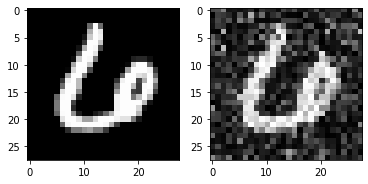

25  :  0.6574108558558354 25
50  :  0.7316401719644237 25
75  :  0.7475519010159319 25
100  :  0.7475519010159319 25
125  :  0.7475519010159319 25
150  :  0.7475519010159319 25
175  :  0.7475519010159319 25
200  :  0.7475519010159319 25
225  :  0.7475519010159319 25
250  :  0.7517247788287413 25
275  :  0.7517247788287413 25
300  :  0.7517247788287413 25
325  :  0.7545719191825977 25
350  :  0.754005939572866 25
375  :  0.7558659635671579 25
400  :  0.7562058178843112 25
425  :  0.7598615165107555 25
450  :  0.7598615165107555 25
475  :  0.7598615165107555 25
500  :  0.7598615165107555 25
525  :  0.7614583504044381 25
550  :  0.7614614963109521 25
575  :  0.7614614963109521 25
600  :  0.7645505798875568 25
625  :  0.764335700730254 25
650  :  0.7649203520045325 25
675  :  0.7649789527568338 25
700  :  0.7671258157140165 25
725  :  0.7671260888311237 25
750  :  0.7677878928515025 25
775  :  0.7698524746103232 25
800  :  0.7698491458559578 25
825  :  0.7707587790052752 25
850  :  0.77090

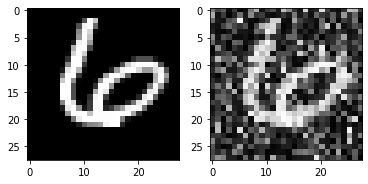

25  :  0.43698604170610666 25
50  :  0.6666847263479179 25
75  :  0.6573064134223615 25
100  :  0.658544036639644 25
125  :  0.6559900279093052 25
150  :  0.6559900279093052 25
175  :  0.6578712395508706 25
200  :  0.6584169142235807 25
225  :  0.6584169142235807 25
250  :  0.6656886813119057 25
275  :  0.6690174800842319 25
300  :  0.6705588614139737 25
325  :  0.6685478870360888 25
350  :  0.6729315066852303 25
375  :  0.6741883546360165 25
400  :  0.6730046452048836 25
425  :  0.6742792085900319 25
450  :  0.6760909286822103 25
475  :  0.6765649804389353 25
500  :  0.6791389287479578 25
525  :  0.6808879904142969 25
550  :  0.6808879904142969 25
575  :  0.6831222523794904 25
600  :  0.6836390719735843 25
625  :  0.6840018861030333 25
650  :  0.6847330991762468 25
675  :  0.6888492473814185 25
700  :  0.6892401085883549 25
725  :  0.6907645653509069 25
750  :  0.6926662408918288 25
775  :  0.6925973700748879 25
800  :  0.6925973700748879 25
825  :  0.692749788918405 25
Time:  78.6566

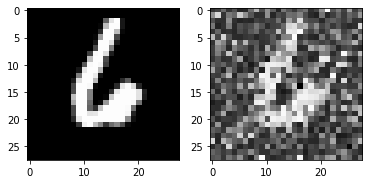

25  :  0.7360511751725436 25
50  :  0.7360511751725436 25
75  :  0.7436843111022433 25
100  :  0.7456952032627563 25
125  :  0.7511623251905981 25
150  :  0.7463411673886176 25
175  :  0.7463411673886176 25
200  :  0.7568840581187579 25
225  :  0.7574833512460382 25
250  :  0.7574833512460382 25
275  :  0.7574833512460382 25
300  :  0.7574833512460382 25
325  :  0.7574833512460382 25
350  :  0.7574833512460382 25
375  :  0.7576620011475286 25
400  :  0.7574833512460382 25
425  :  0.7574833512460382 25
450  :  0.7589352176033134 25
475  :  0.7609774387512462 25
500  :  0.7617499692775176 25
525  :  0.7617930278418792 25
550  :  0.7625181877341726 25
575  :  0.7622042466810233 25
600  :  0.7621825895909818 25
625  :  0.762254214758908 25
650  :  0.7634094999762051 25
675  :  0.763471469630814 25
700  :  0.763471469630814 25
725  :  0.7636836527962009 25
750  :  0.7656545802715761 25
775  :  0.7654238391878652 25
800  :  0.7664990455730162 25
825  :  0.7681694213793375 25
850  :  0.768162

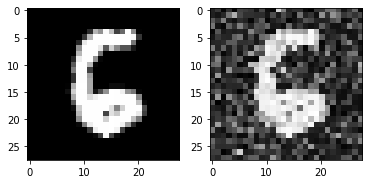

25  :  0.5996200793825959 25
50  :  0.6497589874758359 25
75  :  0.6807289682313141 25
100  :  0.6914431870651391 25
125  :  0.7079634785597319 25
150  :  0.7216167570683771 25
175  :  0.7155160896820728 25
200  :  0.7190790957503163 25
225  :  0.7190790957503163 25
250  :  0.7238840387074316 25
275  :  0.7244359445572235 25
300  :  0.7240451950903731 25
325  :  0.7252668529185817 25
350  :  0.7252668529185817 25
375  :  0.7307884823880636 25
400  :  0.7307884823880636 25
425  :  0.7307884823880636 25
450  :  0.7321300193891827 25
475  :  0.7321300193891827 25
500  :  0.7391244139130919 25
525  :  0.7391244139130919 25
550  :  0.7391244139130919 25
575  :  0.7391811533428053 25
600  :  0.7418846803960143 25
625  :  0.7418792251521114 25
650  :  0.7418792251521114 25
675  :  0.7431581968148524 25
700  :  0.7431667317863498 25
725  :  0.7433459866786862 25
750  :  0.7434477526238092 25
775  :  0.7445703066082637 25
800  :  0.74459866835795 25
825  :  0.7446223359119079 25
850  :  0.74493

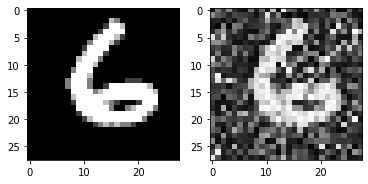

25  :  0.7484249026963771 25
50  :  0.7484249026963771 25
75  :  0.7650297487747023 25
100  :  0.7755182276022132 25
125  :  0.7755182276022132 25
150  :  0.7755182276022132 25
175  :  0.7755182276022132 25
200  :  0.7801737481715504 25
225  :  0.781636799581285 25
250  :  0.781636799581285 25
275  :  0.781636799581285 25
300  :  0.7843484525962412 25
325  :  0.7887766592965062 25
350  :  0.7880029559418908 25
375  :  0.7880029559418908 25
400  :  0.7880029559418908 25
425  :  0.7906727573344395 25
450  :  0.7923242689949782 25
475  :  0.7923869944818942 25
500  :  0.792798199264098 25
525  :  0.7984097916281608 25
550  :  0.7997356067983441 25
575  :  0.7997689140174038 25
600  :  0.7997689140174038 25
625  :  0.8008795290740776 25
650  :  0.8013445236068744 25
675  :  0.8022558274914522 25
700  :  0.8028631900762311 25
725  :  0.8038392735313544 25
750  :  0.8050716698481972 25
775  :  0.8050721058085548 25
800  :  0.8060187383556698 25
825  :  0.8060993454385894 25
850  :  0.8064716

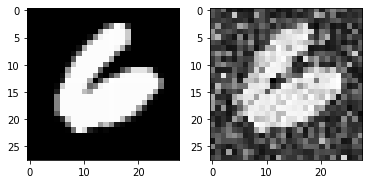

25  :  0.772297084726414 25
50  :  0.772297084726414 25
75  :  0.772297084726414 25
100  :  0.780448318081248 25
125  :  0.780448318081248 25
150  :  0.780448318081248 25
175  :  0.780448318081248 25
200  :  0.780489428915377 25
225  :  0.7812557196220962 25
250  :  0.7815312278031523 25
275  :  0.7815312278031523 25
300  :  0.7869146421313651 25
325  :  0.7877389693396566 25
350  :  0.7878197125107821 25
375  :  0.7906540591794564 25
400  :  0.7941979034015176 25
425  :  0.7988230132756126 25
450  :  0.7988230132756126 25
475  :  0.7988230132756126 25
500  :  0.8039355310260463 25
525  :  0.8038703076165694 25
550  :  0.8045699256739762 25
575  :  0.8052704431227369 25
600  :  0.8058022684288929 25
625  :  0.8062503692228027 25
650  :  0.8058022684288929 25
675  :  0.8089627696045381 25
700  :  0.808962531185959 25
725  :  0.808962531185959 25
750  :  0.8096717990288647 25
775  :  0.8096717990288647 25
800  :  0.8096717990288647 25
Time:  74.58768963813782  seconds
Predicted class:  [

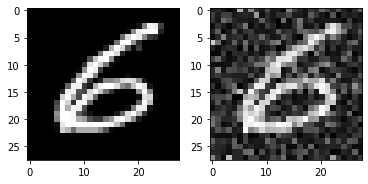

25  :  0.7459682563822132 25
50  :  0.7459682563822132 25
75  :  0.7492506545650952 25
100  :  0.7527618896524815 25
125  :  0.752670206835266 25
150  :  0.7590918467016093 25
175  :  0.7591572009287337 25
200  :  0.7621588058991924 25
225  :  0.7645052912261052 25
250  :  0.7645052912261052 25
275  :  0.765176219563177 25
300  :  0.765176219563177 25
325  :  0.7660510667371514 25
350  :  0.7663254794820489 25
375  :  0.7663254794820489 25
400  :  0.7674011507864884 25
425  :  0.7690988542811551 25
450  :  0.7710712813489642 25
475  :  0.7721788742587918 25
500  :  0.7731006450953856 25
525  :  0.7738674928999038 25
550  :  0.7738674928999038 25
575  :  0.7773254409673265 25
600  :  0.7773215550809216 25
625  :  0.7773215550809216 25
650  :  0.7790270845390097 25
675  :  0.7789297527747436 25
700  :  0.7793549550275712 25
725  :  0.7801802311411716 25
750  :  0.78040214815189 25
775  :  0.7812374193002445 25
800  :  0.7821044670457222 25
Time:  76.38874983787537  seconds
Predicted clas

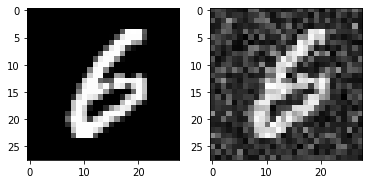

25  :  0.1575046405047507 25
50  :  0.6797551238550799 25
75  :  0.6845680598318443 25
100  :  0.6869810992419911 25
125  :  0.695897600862283 25
150  :  0.695897600862283 25
175  :  0.695897600862283 25
200  :  0.695897600862283 25
225  :  0.695897600862283 25
250  :  0.695897600862283 25
275  :  0.695897600862283 25
300  :  0.695897600862283 25
325  :  0.695897600862283 25
350  :  0.695897600862283 25
375  :  0.695897600862283 25
400  :  0.695897600862283 25
425  :  0.695897600862283 25
450  :  0.695897600862283 25
475  :  0.695897600862283 25
500  :  0.6989461800169786 25
525  :  0.6988159421690231 25
550  :  0.7012611332116923 25
575  :  0.701507684447966 25
600  :  0.701805662189388 25
625  :  0.701805662189388 25
650  :  0.7020631283001402 25
675  :  0.7035369545543444 25
700  :  0.7042741904241834 25
725  :  0.7048028948987592 25
750  :  0.7051034521329654 25
775  :  0.705318254049731 25
800  :  0.7055007463214471 25
825  :  0.708330760859166 25
Time:  81.47762608528137  seconds

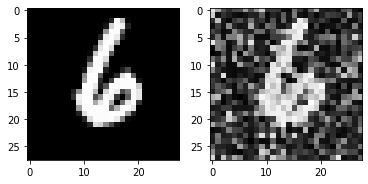

25  :  0.7100975812130741 25
50  :  0.7124167868528855 25
75  :  0.7260581976791984 25
100  :  0.7260581976791984 25
125  :  0.7260581976791984 25
150  :  0.7260581976791984 25
175  :  0.7260581976791984 25
200  :  0.7260581976791984 25
225  :  0.7260581976791984 25
250  :  0.7269884330018299 25
275  :  0.7270201543426391 25
300  :  0.7285592200204831 25
325  :  0.7288853147696872 25
350  :  0.7288853147696872 25
375  :  0.7288853147696872 25
400  :  0.7289419060375962 25
425  :  0.7289608270915386 25
450  :  0.7319081961966726 25
475  :  0.7319081961966726 25
500  :  0.7319516112680738 25
525  :  0.7319516112680738 25
550  :  0.7319516112680738 25
575  :  0.7330440166574896 25
600  :  0.7330440166574896 25
625  :  0.734768984957092 25
650  :  0.7377820038511527 25
675  :  0.7379941922388003 25
700  :  0.7379950352706277 25
725  :  0.7412486748410134 25
750  :  0.7411351541446797 25
775  :  0.7415308771000949 25
800  :  0.7428053521450603 25
825  :  0.7433059299584394 25
850  :  0.7433

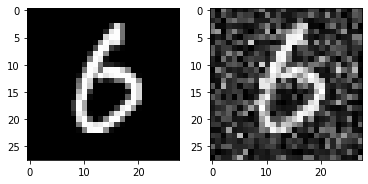

25  :  0.5236189533524644 25
50  :  0.6786276419252852 25
75  :  0.7021442834358221 25
100  :  0.7038362874372538 25
125  :  0.7038362874372538 25
150  :  0.7038362874372538 25
175  :  0.7038362874372538 25
200  :  0.7089525840558748 25
225  :  0.7094357838235258 25
250  :  0.7094357838235258 25
275  :  0.7094357838235258 25
300  :  0.7094357838235258 25
325  :  0.7094357838235258 25
350  :  0.7153895169756217 25
375  :  0.7153895169756217 25
400  :  0.7153895169756217 25
425  :  0.7153895169756217 25
450  :  0.7153895169756217 25
475  :  0.7153895169756217 25
500  :  0.7180184217333635 25
525  :  0.7180184217333635 25
550  :  0.718824378171613 25
575  :  0.7191337634121755 25
600  :  0.718919688329361 25
625  :  0.718919688329361 25
650  :  0.718919688329361 25
675  :  0.718919688329361 25
700  :  0.718919688329361 25
725  :  0.718919688329361 25
750  :  0.7195563289609712 25
775  :  0.7215815830403527 25
800  :  0.7215095844211327 25
825  :  0.7220631771908923 25
850  :  0.7221570046

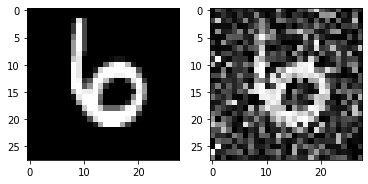

25  :  0.7054145832787626 25
50  :  0.7054145832787626 25
75  :  0.7054145832787626 25
100  :  0.7133810663815308 25
125  :  0.7130999319044313 25
150  :  0.7161002162104974 25
175  :  0.7151089038723062 25
200  :  0.7151089038723062 25
225  :  0.7151089038723062 25
250  :  0.7164982972458248 25
275  :  0.7164982972458248 25
300  :  0.7184152884811014 25
325  :  0.7171095709171479 25
350  :  0.7211900220070422 25
375  :  0.7216117959678051 25
400  :  0.7215726910351543 25
425  :  0.7215726910351543 25
450  :  0.7224453840477174 25
475  :  0.7267830590587692 25
500  :  0.7267830590587692 25
525  :  0.726956479456092 25
550  :  0.7282946504482384 25
575  :  0.7298602037411378 25
600  :  0.730675399178754 25
625  :  0.7315288065201083 25
650  :  0.732126675053139 25
675  :  0.7347773277371696 25
700  :  0.7347773237154454 25
725  :  0.7347773237154454 25
750  :  0.7347773237154454 25
775  :  0.7354082092315855 25
800  :  0.735418664725322 25
Time:  74.59484767913818  seconds
Predicted cla

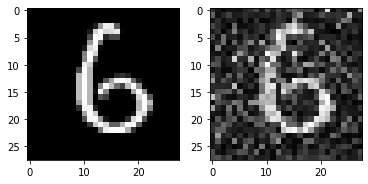

25  :  0.6897628834777644 25
50  :  0.6996428576709115 25
75  :  0.6921719350441147 25
100  :  0.6921719350441147 25
125  :  0.6921719350441147 25
150  :  0.6921719350441147 25
175  :  0.6921719350441147 25
200  :  0.6921719350441147 25
225  :  0.6921719350441147 25
250  :  0.6921719350441147 25
275  :  0.6921719350441147 25
300  :  0.6939767973890644 25
325  :  0.6935939927612028 25
350  :  0.694300498550312 25
375  :  0.694300498550312 25
400  :  0.694300498550312 25
425  :  0.694300498550312 25
450  :  0.6944549745619878 25
475  :  0.7005847683115822 25
500  :  0.6999617970169163 25
525  :  0.7013281598087877 25
550  :  0.7014870450025302 25
575  :  0.7033053897104322 25
600  :  0.7059668088996669 25
625  :  0.7067865119498012 25
650  :  0.7070276386560531 25
675  :  0.7073239427322436 25
700  :  0.7073239427322436 25
725  :  0.7074283813420184 25
750  :  0.7098168519053413 25
775  :  0.7108191138793536 25
800  :  0.7108191138793536 25
Time:  75.05580544471741  seconds
Predicted cla

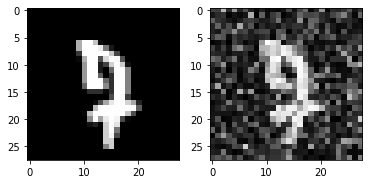

25  :  0.807747924530704 25
50  :  0.8118562149906259 25
75  :  0.807747924530704 25
100  :  0.8176128659066331 25
125  :  0.8157374033745894 25
150  :  0.819712327483692 25
175  :  0.819712327483692 25
200  :  0.819712327483692 25
225  :  0.8204573080140464 25
250  :  0.8227965870186766 25
275  :  0.8222835900709158 25
300  :  0.8292746093999859 25
325  :  0.8290499449340905 25
350  :  0.8290499449340905 25
375  :  0.8290499449340905 25
400  :  0.8290499449340905 25
425  :  0.8291264908356983 25
450  :  0.828881353456902 25
475  :  0.8321185999596457 25
500  :  0.8383205334363852 25
525  :  0.8382520747496036 25
550  :  0.8382520747496036 25
575  :  0.8401082898775458 25
600  :  0.8405394358085378 25
625  :  0.8408995600693727 25
650  :  0.8418127756604742 25
675  :  0.8431379523880617 25
700  :  0.843842267511385 25
725  :  0.8452846259654868 25
750  :  0.846815899445692 25
775  :  0.8515987859926584 25
800  :  0.8515987859926584 25
Time:  75.12118864059448  seconds
Predicted class: 

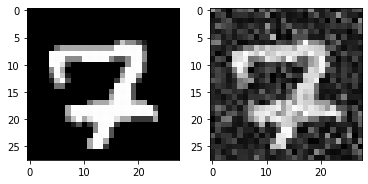

25  :  0.7069401685887184 25
50  :  0.7069401685887184 25
75  :  0.7073851406637732 25
100  :  0.708266782756266 25
125  :  0.7169199124059108 25
150  :  0.7160968750274899 25
175  :  0.7163536104327978 25
200  :  0.7160427738345551 25
225  :  0.7160427738345551 25
250  :  0.7160427738345551 25
275  :  0.7160427738345551 25
300  :  0.7160427738345551 25
325  :  0.723170677728347 25
350  :  0.7219073090094645 25
375  :  0.7219073090094645 25
400  :  0.7219073090094645 25
425  :  0.7219073090094645 25
450  :  0.7219073090094645 25
475  :  0.7219073090094645 25
500  :  0.7219073090094645 25
525  :  0.7223201537144675 25
550  :  0.7245836584105027 25
575  :  0.7252064247178615 25
600  :  0.7254481134562099 25
625  :  0.7260267267903593 25
650  :  0.7259896914506939 25
675  :  0.727334119970627 25
700  :  0.7286872630865155 25
725  :  0.7286879131925186 25
750  :  0.7286879131925186 25
775  :  0.7286879131925186 25
800  :  0.7304974966141808 25
Time:  73.9310531616211  seconds
Predicted cla

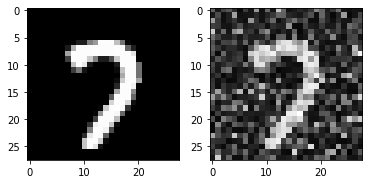

25  :  0.12260311460913911 25
50  :  0.23959102175578628 25
75  :  0.43429672745060427 25
100  :  0.6673431970003936 25
125  :  0.6762373145892127 25
150  :  0.6782181464174767 25
175  :  0.6782181464174767 25
200  :  0.6782181464174767 25
225  :  0.6839623125083774 25
250  :  0.6839623125083774 25
275  :  0.6839623125083774 25
300  :  0.6839623125083774 25
325  :  0.6840354820808363 25
350  :  0.6863109701759029 25
375  :  0.6888977079174982 25
400  :  0.6888977079174982 25
425  :  0.690697072616937 25
450  :  0.6902990914883776 25
475  :  0.6934777165503425 25
500  :  0.6932039701784134 25
525  :  0.6936980284517394 25
550  :  0.6936440429523842 25
575  :  0.6954669708890342 25
600  :  0.7007503736677385 25
625  :  0.7007503736677385 25
650  :  0.7012280740046117 25
675  :  0.7020195022026016 25
700  :  0.7024783367373449 25
725  :  0.7026901822792908 25
750  :  0.7028821824366289 25
775  :  0.7036125792083245 25
800  :  0.7040411744363254 25
825  :  0.7040411744363254 25
850  :  0.7

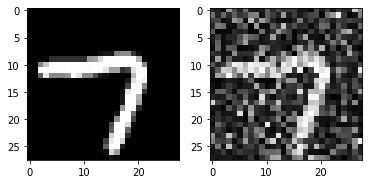

25  :  0.7168786066794152 25
50  :  0.7168786066794152 25
75  :  0.7168786066794152 25
100  :  0.7168786066794152 25
125  :  0.7304859746229482 25
150  :  0.726733745471997 25
175  :  0.726733745471997 25
200  :  0.726733745471997 25
225  :  0.726733745471997 25
250  :  0.726733745471997 25
275  :  0.726733745471997 25
300  :  0.726733745471997 25
325  :  0.7267673751817916 25
350  :  0.7269784413791623 25
375  :  0.7269784413791623 25
400  :  0.7269784413791623 25
425  :  0.7269784413791623 25
450  :  0.7269784413791623 25
475  :  0.7318456573544471 25
500  :  0.7310266705659261 25
525  :  0.7310266705659261 25
550  :  0.7310266705659261 25
575  :  0.7310266705659261 25
600  :  0.7310266705659261 25
625  :  0.7316059853100557 25
650  :  0.7377237403615005 25
675  :  0.7371645152842449 25
700  :  0.7371645152842449 25
725  :  0.7371645152842449 25
750  :  0.7371645152842449 25
775  :  0.7371645152842449 25
800  :  0.7371645152842449 25
825  :  0.7371645152842449 25
850  :  0.7371645152

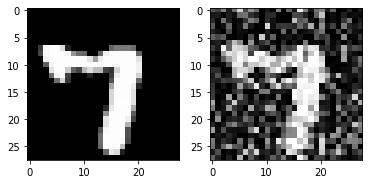

25  :  0.6358886744724621 25
50  :  0.6391361735486241 25
75  :  0.6436087768861929 25
100  :  0.6436087768861929 25
125  :  0.6436087768861929 25
150  :  0.6436087768861929 25
175  :  0.6438131163741321 25
200  :  0.6470240016809137 25
225  :  0.6477519230372452 25
250  :  0.6501642842487232 25
275  :  0.6503817459704176 25
300  :  0.6513116168250436 25
325  :  0.6515461675387335 25
350  :  0.654731209913889 25
375  :  0.65548871737822 25
400  :  0.6580884247962874 25
425  :  0.6585012685857063 25
450  :  0.6585012685857063 25
475  :  0.6588343689768406 25
500  :  0.65962783504617 25
525  :  0.6642734960176463 25
550  :  0.6642975560451662 25
575  :  0.6651558556643994 25
600  :  0.6655182786540316 25
625  :  0.6655435009223204 25
650  :  0.6661503775002661 25
675  :  0.6663321092417483 25
700  :  0.6668350307082687 25
725  :  0.6685463677255021 25
750  :  0.6688749637619491 25
775  :  0.6691833165684129 25
800  :  0.6697097645598509 25
Time:  73.37991857528687  seconds
Predicted clas

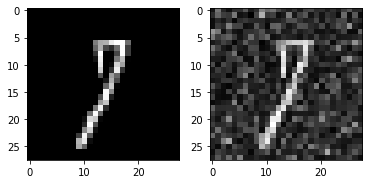

25  :  0.7341294787772044 25
50  :  0.7341294787772044 25
75  :  0.7312468350269468 25
100  :  0.7310974636035951 25
125  :  0.7310974636035951 25
150  :  0.7323079633645958 25
175  :  0.7310974636035951 25
200  :  0.7310974636035951 25
225  :  0.7357548329933624 25
250  :  0.7396806746229462 25
275  :  0.7393188851767785 25
300  :  0.7393188851767785 25
325  :  0.7393188851767785 25
350  :  0.7393188851767785 25
375  :  0.7396247453375779 25
400  :  0.7393188851767785 25
425  :  0.7393188851767785 25
450  :  0.7393188851767785 25
475  :  0.7393188851767785 25
500  :  0.7393188851767785 25
525  :  0.7393188851767785 25
550  :  0.7401685288508368 25
575  :  0.7400871835673919 25
600  :  0.7400871835673919 25
625  :  0.7422822962575515 25
650  :  0.7423968710358313 25
675  :  0.7455781930062477 25
700  :  0.7456736299984317 25
725  :  0.7506545145105549 25
750  :  0.750968230780678 25
775  :  0.750968230780678 25
800  :  0.750968230780678 25
Time:  72.98088264465332  seconds
Predicted cl

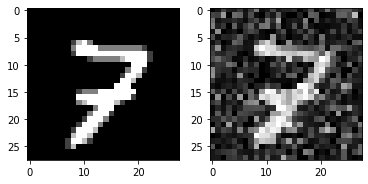

25  :  0.6861304562432856 25
50  :  0.6861304562432856 25
75  :  0.7083242926290967 25
100  :  0.7087831336903366 25
125  :  0.7115862924419691 25
150  :  0.7115862924419691 25
175  :  0.7115862924419691 25
200  :  0.7115862924419691 25
225  :  0.7180565943868464 25
250  :  0.7191221217382644 25
275  :  0.7191221217382644 25
300  :  0.7226989450057067 25
325  :  0.7228989084970394 25
350  :  0.7228989084970394 25
375  :  0.726077277332924 25
400  :  0.7340245486317791 25
425  :  0.7344432909808044 25
450  :  0.7344432909808044 25
475  :  0.7344432909808044 25
500  :  0.736129879215697 25
525  :  0.7362103720560593 25
550  :  0.7376068291550726 25
575  :  0.7374378786564425 25
600  :  0.7384514442165411 25
625  :  0.7384318770080538 25
650  :  0.7385149428202844 25
675  :  0.7390557869633226 25
700  :  0.739963466133336 25
725  :  0.739963466133336 25
750  :  0.739963466133336 25
775  :  0.7415170808051854 25
800  :  0.7434722815497051 25
825  :  0.7443383955948911 25
850  :  0.74546171

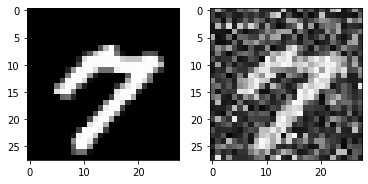

25  :  0.715754324591826 25
50  :  0.715754324591826 25
75  :  0.715754324591826 25
100  :  0.715754324591826 25
125  :  0.715754324591826 25
150  :  0.715754324591826 25
175  :  0.715754324591826 25
200  :  0.715754324591826 25
225  :  0.715754324591826 25
250  :  0.715754324591826 25
275  :  0.715754324591826 25
300  :  0.715754324591826 25
325  :  0.715754324591826 25
350  :  0.715754324591826 25
375  :  0.7222901612081271 25
400  :  0.7253356327668938 25
425  :  0.7231804499354912 25
450  :  0.7245684509308409 25
475  :  0.7260287599997118 25
500  :  0.7275479610285192 25
525  :  0.7270595699821365 25
550  :  0.7270595699821365 25
575  :  0.7281865704999323 25
600  :  0.7283254080856867 25
625  :  0.7283254080856867 25
650  :  0.728350354246619 25
675  :  0.7287707765739294 25
700  :  0.7287707765739294 25
725  :  0.7287707765739294 25
750  :  0.7290940278015888 25
775  :  0.7298136299186996 25
800  :  0.7298093332530387 25
Time:  73.61937403678894  seconds
Predicted class:  [2]


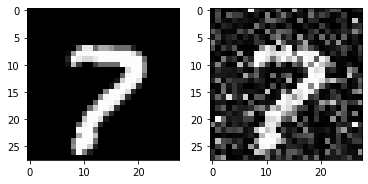

25  :  0.6669606268932451 25
50  :  0.6669606268932451 25
75  :  0.669129238632634 25
100  :  0.6722265157660927 25
125  :  0.6755574826022741 25
150  :  0.674662817470065 25
175  :  0.674662817470065 25
200  :  0.674662817470065 25
225  :  0.674662817470065 25
250  :  0.674662817470065 25
275  :  0.6773841140900994 25
300  :  0.6773841140900994 25
325  :  0.6773841140900994 25
350  :  0.6817400658167365 25
375  :  0.6834117398810944 25
400  :  0.6834117398810944 25
425  :  0.6834117398810944 25
450  :  0.6834117398810944 25
475  :  0.6834117398810944 25
500  :  0.6834117398810944 25
525  :  0.6834117398810944 25
550  :  0.6834117398810944 25
575  :  0.6834117398810944 25
600  :  0.6834117398810944 25
625  :  0.6834117398810944 25
650  :  0.6834117398810944 25
675  :  0.6846074470347432 25
700  :  0.6846074470347432 25
725  :  0.6846074470347432 25
750  :  0.6846074470347432 25
775  :  0.6857185054524165 25
800  :  0.685970202481516 25
Time:  75.84575867652893  seconds
Predicted class:

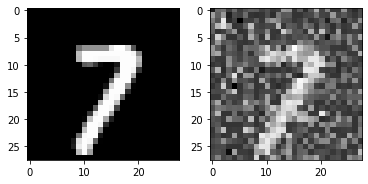

25  :  0.6747673970551767 25
50  :  0.6747673970551767 25
75  :  0.6747673970551767 25
100  :  0.6747673970551767 25
125  :  0.6747673970551767 25
150  :  0.6747673970551767 25
175  :  0.6762736279287713 25
200  :  0.6747673970551767 25
225  :  0.6747673970551767 25
250  :  0.6747673970551767 25
275  :  0.6747673970551767 25
300  :  0.6747673970551767 25
325  :  0.6747673970551767 25
350  :  0.6747673970551767 25
375  :  0.6747673970551767 25
400  :  0.6752466397546399 25
425  :  0.6752466397546399 25
450  :  0.6783937697593098 25
475  :  0.6788432734889135 25
500  :  0.6782773886076818 25
525  :  0.6818453120982666 25
550  :  0.6818453120982666 25
575  :  0.6818453120982666 25
600  :  0.6818453120982666 25
625  :  0.6818453120982666 25
650  :  0.6818453120982666 25
675  :  0.6822831044024062 25
700  :  0.6870806425124301 25
725  :  0.6881854651314463 25
750  :  0.6881854651314463 25
775  :  0.6906376438755257 25
800  :  0.6906376438755257 25
Time:  73.13593316078186  seconds
Predicted

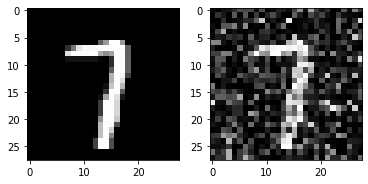

25  :  0.621428275435916 25
50  :  0.6258110358243636 25
75  :  0.6418987217867183 25
100  :  0.6402401397369344 25
125  :  0.6467734638038722 25
150  :  0.6437847942516085 25
175  :  0.6498296551236027 25
200  :  0.6471131173342164 25
225  :  0.6480153125146261 25
250  :  0.6490663078527212 25
275  :  0.6515940337860375 25
300  :  0.6515940337860375 25
325  :  0.6526157970536559 25
350  :  0.6543434495524343 25
375  :  0.6543434495524343 25
400  :  0.6584647002491789 25
425  :  0.6584647002491789 25
450  :  0.6615581323719932 25
475  :  0.6614600763443536 25
500  :  0.6614600763443536 25
525  :  0.6635576434119287 25
550  :  0.6635576434119287 25
575  :  0.6652646611130022 25
600  :  0.6652646611130022 25
625  :  0.6652646611130022 25
650  :  0.6657749908075927 25
675  :  0.6657749908075927 25
700  :  0.6657749908075927 25
725  :  0.6658068003630759 25
750  :  0.6666120232280142 25
775  :  0.6667314322542225 25
800  :  0.6667456062797624 25
825  :  0.6673912378819074 25
850  :  0.6675

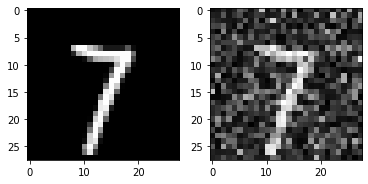

25  :  0.5945467316391924 25
50  :  0.5984579583839249 25
75  :  0.6140749094047888 25
100  :  0.6156688786944503 25
125  :  0.6160148436571896 25
150  :  0.6156688786944503 25
175  :  0.6180851387725563 25
200  :  0.6159194096917557 25
225  :  0.6159194096917557 25
250  :  0.6200510494233582 25
275  :  0.6256786924693041 25
300  :  0.6256786924693041 25
325  :  0.6256786924693041 25
350  :  0.6256786924693041 25
375  :  0.6256786924693041 25
400  :  0.6256786924693041 25
425  :  0.6263754253212304 25
450  :  0.6261531933456015 25
475  :  0.6273734773876563 25
500  :  0.6273734773876563 25
525  :  0.6273734773876563 25
550  :  0.628405750085914 25
575  :  0.6292333174416167 25
600  :  0.6306887433937318 25
625  :  0.6306887433937318 25
650  :  0.6306887433937318 25
675  :  0.6306887433937318 25
700  :  0.6306887433937318 25
725  :  0.6306887433937318 25
750  :  0.6326841381528588 25
775  :  0.6326834686933596 25
800  :  0.6330796634167447 25
825  :  0.6335510058154759 25
850  :  0.6339

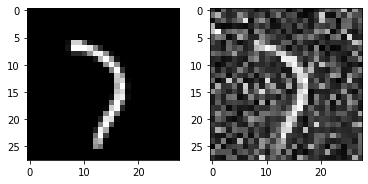

25  :  -0.27894941858747424 25
50  :  -0.27894941858747424 25
75  :  -0.2756578916930914 25
100  :  -0.27576363561969885 25
125  :  -0.2755559688917608 25
150  :  -0.2742404540207617 25
175  :  -0.2742451882683663 25
200  :  -0.27213087097221506 25
225  :  -0.2653984621548746 25
250  :  -0.26382160888709205 25
275  :  -0.261390451583846 25
300  :  -0.261181791333886 25
325  :  -0.26120660758503633 25
350  :  -0.2604161488494803 25
375  :  -0.25914635693534327 25
400  :  -0.25914507310251966 25
425  :  -0.25914507310251966 25
450  :  -0.2573096572982489 25
475  :  -0.2572175121917156 25
500  :  -0.2566391523307121 25
525  :  -0.25662898270673407 25
550  :  -0.2539718862008582 25
575  :  -0.2539718862008582 25
600  :  -0.2539718862008582 25
625  :  -0.25325083403838294 25
650  :  -0.2522381056190075 25
675  :  -0.25050059936404034 25
700  :  -0.25050078943830834 25
725  :  -0.2494507051764639 25
750  :  -0.2494491250437051 25
775  :  -0.2490546090565205 25
800  :  -0.24885964373863234 25

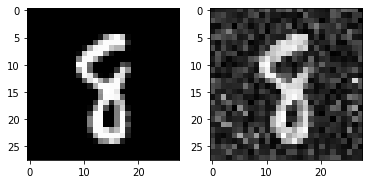

25  :  -0.25720062002904653 25
50  :  -0.25690270041081237 25
75  :  -0.24258879020054264 25
100  :  -0.24206866069935212 25
125  :  -0.2342390774983148 25
150  :  -0.23372352660536316 25
175  :  -0.22937469170919877 25
200  :  -0.2293851069851261 25
225  :  -0.2293124195465968 25
250  :  -0.22281794875077393 25
275  :  -0.22281794875077393 25
300  :  -0.22281794875077393 25
325  :  -0.22281794875077393 25
350  :  -0.22243576165068268 25
375  :  -0.221858652171124 25
400  :  -0.22185858130372155 25
425  :  -0.22185858130372155 25
450  :  -0.22155431945967735 25
475  :  -0.22151165821205582 25
500  :  -0.2202069841022054 25
525  :  -0.21988224595403488 25
550  :  -0.21984447174595495 25
575  :  -0.21825491842956124 25
600  :  -0.21802134958048208 25
625  :  -0.21787710790512027 25
650  :  -0.21595629823275914 25
675  :  -0.21595845467023173 25
700  :  -0.21595845467023173 25
725  :  -0.21526016753637078 25
750  :  -0.2150782436303072 25
775  :  -0.21507837412260017 25
800  :  -0.2150783

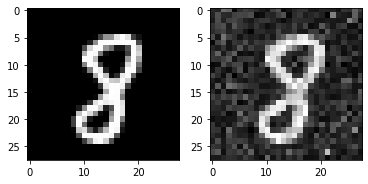

25  :  -0.2293793809840961 25
50  :  -0.2293793809840961 25
75  :  -0.22133319503572702 25
100  :  -0.2212985315088722 25
125  :  -0.21132959117705102 25
150  :  -0.20119990859645515 25
175  :  -0.19976336447881005 25
200  :  -0.19976747260517252 25
225  :  -0.19976747260517252 25
250  :  -0.19976747260517252 25
275  :  -0.19976747260517252 25
300  :  -0.19543157260719174 25
325  :  -0.19503945042927873 25
350  :  -0.19338718919577524 25
375  :  -0.19211489609460258 25
400  :  -0.1918089389333945 25
425  :  -0.19026077976249034 25
450  :  -0.18989329322198129 25
475  :  -0.18989240043308264 25
500  :  -0.18945327887719882 25
525  :  -0.18904898254759467 25
550  :  -0.18858190740382613 25
575  :  -0.18779150326056065 25
600  :  -0.18779150326056065 25
625  :  -0.1871008297164094 25
650  :  -0.1871008297164094 25
675  :  -0.18695982729282262 25
700  :  -0.1865999680972495 25
725  :  -0.18653099231004922 25
750  :  -0.18653099231004916 25
775  :  -0.18653099231004916 25
800  :  -0.1860418

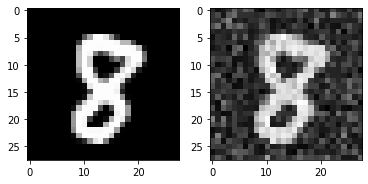

25  :  -0.22950037262919165 25
50  :  -0.22762815519855822 25
75  :  -0.22542333438986817 25
100  :  -0.21287529727665777 25
125  :  -0.21287529727665777 25
150  :  -0.2119986481966753 25
175  :  -0.2087283177752775 25
200  :  -0.20669309751991105 25
225  :  -0.20669309751991105 25
250  :  -0.20550540155169306 25
275  :  -0.20249408280817005 25
300  :  -0.2024948482427253 25
325  :  -0.2024948482427253 25
350  :  -0.2022569246855817 25
375  :  -0.2011107377842168 25
400  :  -0.20065204326080271 25
425  :  -0.20065189821754198 25
450  :  -0.19958225580973177 25
475  :  -0.1987424509999543 25
500  :  -0.19852219068434684 25
525  :  -0.19520614570843503 25
550  :  -0.19507790754463422 25
575  :  -0.19507790754463422 25
600  :  -0.19507790754463422 25
625  :  -0.19507790754463422 25
650  :  -0.19460491168031585 25
675  :  -0.1939899087041917 25
700  :  -0.1936912918122491 25
725  :  -0.19283262611587199 25
750  :  -0.19283262611587199 25
775  :  -0.19255121013086912 25
800  :  -0.192250476

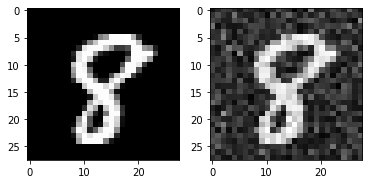

25  :  -0.22822923475614476 25
50  :  -0.2235749083041067 25
75  :  -0.2215751851054144 25
100  :  -0.21628309970038684 25
125  :  -0.21231398340426072 25
150  :  -0.2072070864962111 25
175  :  -0.19323860419076233 25
200  :  -0.19323860419076233 25
225  :  -0.19323860419076233 25
250  :  -0.19323860419076233 25
275  :  -0.19323860419076233 25
300  :  -0.1913459923268091 25
325  :  -0.1913459923268091 25
350  :  -0.1913459923268091 25
375  :  -0.19100151925859232 25
400  :  -0.18950206744464138 25
425  :  -0.18828466245193393 25
450  :  -0.18828466245193393 25
475  :  -0.18828466245193393 25
500  :  -0.18612454593118866 25
525  :  -0.1856340784093261 25
550  :  -0.1856340784093261 25
575  :  -0.1856340784093261 25
600  :  -0.18562289612374394 25
625  :  -0.18562289612374394 25
650  :  -0.18492530715177408 25
675  :  -0.18492530715177408 25
700  :  -0.18451278647248265 25
725  :  -0.1840655849758996 25
750  :  -0.18374336527487634 25
775  :  -0.18356903886724812 25
800  :  -0.1834791805

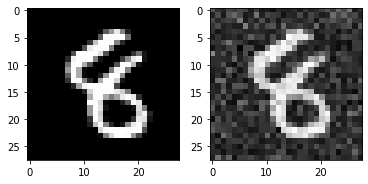

25  :  -0.22462930963712535 25
50  :  -0.21586635983489488 25
75  :  -0.21450101884342715 25
100  :  -0.2135974887524119 25
125  :  -0.20969958571631653 25
150  :  -0.20677571662747612 25
175  :  -0.2027211061114345 25
200  :  -0.19473480920459812 25
225  :  -0.19473480920459812 25
250  :  -0.19473480920459812 25
275  :  -0.19473480920459812 25
300  :  -0.19452226673261508 25
325  :  -0.1900541304730584 25
350  :  -0.1900541304730584 25
375  :  -0.1894124877350742 25
400  :  -0.1888560927198023 25
425  :  -0.18740908364776215 25
450  :  -0.18651679604560972 25
475  :  -0.18640230415767528 25
500  :  -0.18538714862492212 25
525  :  -0.18439308153327144 25
550  :  -0.18438288256800361 25
575  :  -0.18438288924825486 25
600  :  -0.18438288924825486 25
625  :  -0.1842231312715032 25
650  :  -0.18373290022813832 25
675  :  -0.1835794574962641 25
700  :  -0.1830328888538182 25
725  :  -0.18233841948986812 25
750  :  -0.18181936117229386 25
775  :  -0.18103474341118425 25
800  :  -0.180296699

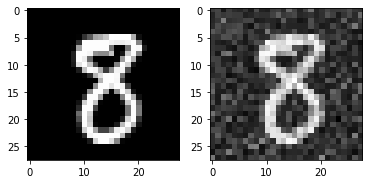

25  :  -0.2518269009696479 25
50  :  -0.24851555176198536 25
75  :  -0.24833615286544697 25
100  :  -0.24605078998913676 25
125  :  -0.2416619449078088 25
150  :  -0.23200162630524568 25
175  :  -0.22868968676783813 25
200  :  -0.2287162029195156 25
225  :  -0.22464129076556322 25
250  :  -0.22464129076556322 25
275  :  -0.22047084198210581 25
300  :  -0.22047467147922362 25
325  :  -0.21985971170230445 25
350  :  -0.21985971170230445 25
375  :  -0.21985971170230445 25
400  :  -0.21985971170230445 25
425  :  -0.21888266601526357 25
450  :  -0.21781032112524584 25
475  :  -0.21769293774351128 25
500  :  -0.21715087544705525 25
525  :  -0.21680911952789406 25
550  :  -0.21554754842071805 25
575  :  -0.21554754619742927 25
600  :  -0.21554754619742927 25
625  :  -0.21547802847785869 25
650  :  -0.21515525906278565 25
675  :  -0.21515520996276621 25
700  :  -0.21498200275707524 25
725  :  -0.21467847453744954 25
750  :  -0.21433264604173508 25
775  :  -0.21409478686581662 25
800  :  -0.214

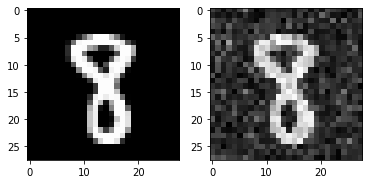

25  :  0.7263100156285726 25
50  :  0.7263100156285726 25
75  :  0.7263100156285726 25
100  :  0.7518608840475325 25
125  :  0.7515812109519855 25
150  :  0.7515812109519855 25
175  :  0.7515812109519855 25
200  :  0.7515812109519855 25
225  :  0.7521645144014282 25
250  :  0.7515812109519855 25
275  :  0.7515812109519855 25
300  :  0.7515812109519855 25
325  :  0.7523963654965725 25
350  :  0.7537753776558228 25
375  :  0.7537753776558228 25
400  :  0.7545214873117743 25
425  :  0.7558067467175371 25
450  :  0.7565455450123857 25
475  :  0.7600177102892567 25
500  :  0.7598029979710991 25
525  :  0.7604175187418015 25
550  :  0.7639194040223358 25
575  :  0.7717510162114031 25
600  :  0.7709983583470372 25
625  :  0.7739894690966715 25
650  :  0.7730793366970705 25
675  :  0.7730793366970705 25
700  :  0.7730793366970705 25
725  :  0.7741282099594848 25
750  :  0.7741279752941195 25
775  :  0.7741279752941195 25
800  :  0.7742937522747751 25
825  :  0.7742937522747751 25
850  :  0.775

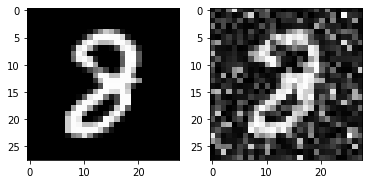

25  :  -0.17282214207463065 25
50  :  -0.15734690201731827 25
75  :  -0.15734690201731827 25
100  :  -0.15734690201731827 25
125  :  -0.1520490947080982 25
150  :  -0.14652621554269846 25
175  :  -0.1465621283496525 25
200  :  -0.14190579732746872 25
225  :  -0.14193791630299385 25
250  :  -0.14073204449395388 25
275  :  -0.1407739347733769 25
300  :  -0.13873083051732438 25
325  :  -0.1353129204666566 25
350  :  -0.1353129204666566 25
375  :  -0.1353129204666566 25
400  :  -0.1348574833505089 25
425  :  -0.13441790754800126 25
450  :  -0.13243264669652732 25
475  :  -0.13243264669652732 25
500  :  -0.13243264669652732 25
525  :  -0.13236769410182203 25
550  :  -0.13131181618429016 25
575  :  -0.13131181618429016 25
600  :  -0.13080037798119665 25
625  :  -0.12938759277233142 25
650  :  -0.12938791851070564 25
675  :  -0.12889695347641406 25
700  :  -0.1270283689217226 25
725  :  -0.12649432628000967 25
750  :  -0.12616130165901707 25
775  :  -0.1261345510233967 25
800  :  -0.125821920

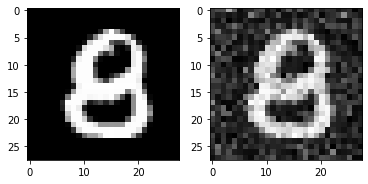

25  :  -0.21879393109286943 25
50  :  -0.20051359469617497 25
75  :  -0.19856216374000968 25
100  :  -0.19856216374000968 25
125  :  -0.19856216374000968 25
150  :  -0.195628140258997 25
175  :  -0.195628140258997 25
200  :  -0.19249849925158902 25
225  :  -0.18788997877805325 25
250  :  -0.18392258458482624 25
275  :  -0.18383065393890968 25
300  :  -0.18233167852737908 25
325  :  -0.1819703359111292 25
350  :  -0.1817998145450474 25
375  :  -0.17993992576962953 25
400  :  -0.17993992576962953 25
425  :  -0.17874705662585577 25
450  :  -0.17833178297764507 25
475  :  -0.17833121676604025 25
500  :  -0.17790285139133988 25
525  :  -0.17707835646210351 25
550  :  -0.17678221892026613 25
575  :  -0.1755506236310393 25
600  :  -0.17510317500682337 25
625  :  -0.17467753838442734 25
650  :  -0.173796347277285 25
675  :  -0.173796347277285 25
700  :  -0.173796347277285 25
725  :  -0.17335329269926386 25
750  :  -0.17321777853365183 25
775  :  -0.1730317873819845 25
800  :  -0.17300286366674

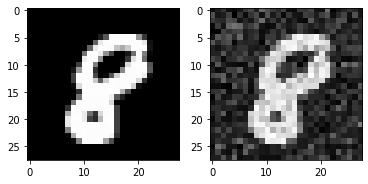

25  :  -0.21924517524687664 25
50  :  -0.21924517524687664 25
75  :  -0.21257531364137183 25
100  :  -0.21067667338005125 25
125  :  -0.2106785715231318 25
150  :  -0.20803121725847806 25
175  :  -0.20694892138377508 25
200  :  -0.2000034602962809 25
225  :  -0.19613681098173918 25
250  :  -0.19607709002963897 25
275  :  -0.19607709002963897 25
300  :  -0.19607709002963897 25
325  :  -0.1943661547951651 25
350  :  -0.19037785395097817 25
375  :  -0.18998928496605583 25
400  :  -0.18998928496605583 25
425  :  -0.18835387353161348 25
450  :  -0.1873664317845128 25
475  :  -0.1867137993981347 25
500  :  -0.1867137993981347 25
525  :  -0.1867137993981347 25
550  :  -0.18608959044765655 25
575  :  -0.18448743448140553 25
600  :  -0.18448743448140553 25
625  :  -0.1833504762858683 25
650  :  -0.1829481274908601 25
675  :  -0.1829481274908601 25
700  :  -0.18284246869802767 25
725  :  -0.18208701413119105 25
750  :  -0.18208701413119105 25
775  :  -0.18208701413119105 25
800  :  -0.1810265053

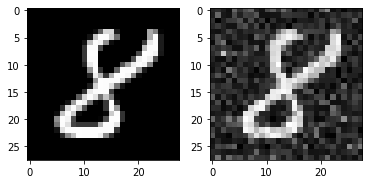

25  :  -0.24329274098033088 25
50  :  -0.23530547513498545 25
75  :  -0.2323665520028601 25
100  :  -0.22537920958002122 25
125  :  -0.22545806422831782 25
150  :  -0.21811746157251677 25
175  :  -0.21811886760409416 25
200  :  -0.21811886760409416 25
225  :  -0.21811886760409416 25
250  :  -0.21703405044516033 25
275  :  -0.21703543152477278 25
300  :  -0.21703543152477278 25
325  :  -0.2169829978490705 25
350  :  -0.21698222131430994 25
375  :  -0.21405137907103133 25
400  :  -0.21334400470980946 25
425  :  -0.20793533048281287 25
450  :  -0.20794112827840522 25
475  :  -0.20794112827840522 25
500  :  -0.20794112827840522 25
525  :  -0.20794112827840522 25
550  :  -0.20794112827840522 25
575  :  -0.20732177987903844 25
600  :  -0.20589880268995658 25
625  :  -0.20494116391927453 25
650  :  -0.20455090463040126 25
675  :  -0.20279969517156343 25
700  :  -0.20186844758841022 25
725  :  -0.20186844758841022 25
750  :  -0.20186844758841022 25
775  :  -0.20186844758841022 25
800  :  -0.20

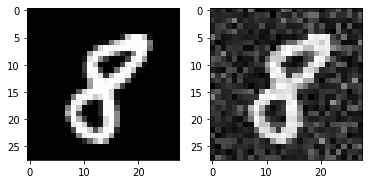

25  :  0.7206585340960716 25
50  :  0.7206585340960716 25
75  :  0.7204036622092301 25
100  :  0.7232374793431526 25
125  :  0.7232374793431526 25
150  :  0.7232374793431526 25
175  :  0.7232374793431526 25
200  :  0.7232374793431526 25
225  :  0.7313059277066688 25
250  :  0.7313936752926352 25
275  :  0.7313936752926352 25
300  :  0.7313936752926352 25
325  :  0.7324555906701617 25
350  :  0.7324555906701617 25
375  :  0.7324555906701617 25
400  :  0.7324555906701617 25
425  :  0.7331890670883249 25
450  :  0.735977518840815 25
475  :  0.7357262595216425 25
500  :  0.7390323481174653 25
525  :  0.7389960047233362 25
550  :  0.7389960047233362 25
575  :  0.7389960047233362 25
600  :  0.7401459113465961 25
625  :  0.739762742491387 25
650  :  0.7394195605546727 25
675  :  0.742751947139032 25
700  :  0.7430536277726979 25
725  :  0.744005276156321 25
750  :  0.7443825519187544 25
775  :  0.7455054769740895 25
800  :  0.7458917653737965 25
Time:  69.7677104473114  seconds
Predicted clas

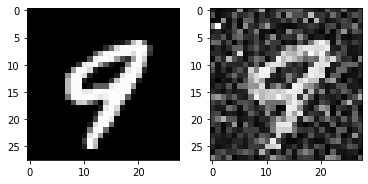

25  :  0.7154497649863534 25
50  :  0.7362937267337655 25
75  :  0.7309565988602102 25
100  :  0.7309565988602102 25
125  :  0.7309565988602102 25
150  :  0.733839970660186 25
175  :  0.733270890444971 25
200  :  0.733789862523938 25
225  :  0.7364180514784363 25
250  :  0.7400669454363887 25
275  :  0.7390610972240554 25
300  :  0.7408488376405252 25
325  :  0.7398558058894382 25
350  :  0.7468607327135124 25
375  :  0.7468607327135124 25
400  :  0.7468607327135124 25
425  :  0.7468607327135124 25
450  :  0.7468607327135124 25
475  :  0.7468607327135124 25
500  :  0.7468607327135124 25
525  :  0.7473272760663068 25
550  :  0.7483963649639304 25
575  :  0.7508823425088584 25
600  :  0.7515507149079175 25
625  :  0.7512690863638475 25
650  :  0.7512690863638475 25
675  :  0.7512690863638475 25
700  :  0.7512690863638475 25
725  :  0.7528269799483582 25
750  :  0.7528268796181546 25
775  :  0.7539837385327949 25
800  :  0.7546243988341671 25
825  :  0.7546115786166487 25
Time:  71.523158

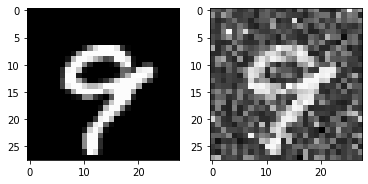

25  :  0.6992750688624386 25
50  :  0.7022103243565305 25
75  :  0.7054126983054502 25
100  :  0.7054126983054502 25
125  :  0.7104693522240002 25
150  :  0.7104693522240002 25
175  :  0.7104693522240002 25
200  :  0.7104693522240002 25
225  :  0.7104693522240002 25
250  :  0.7104693522240002 25
275  :  0.7104693522240002 25
300  :  0.7104693522240002 25
325  :  0.720412026065097 25
350  :  0.720412026065097 25
375  :  0.720412026065097 25
400  :  0.7212778613703972 25
425  :  0.7207411789602955 25
450  :  0.7207468632056901 25
475  :  0.72073031640852 25
500  :  0.7226560516152973 25
525  :  0.7234778186955337 25
550  :  0.7234778186955337 25
575  :  0.7234778186955337 25
600  :  0.7234778186955337 25
625  :  0.7234778186955337 25
650  :  0.7243822377343011 25
675  :  0.7243822377343011 25
700  :  0.7249003500235429 25
725  :  0.7257334293769483 25
750  :  0.726553608712052 25
775  :  0.7266998680163452 25
800  :  0.7272762257071591 25
Time:  70.19881749153137  seconds
Predicted class

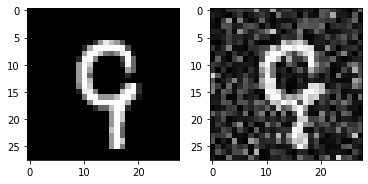

25  :  0.7307891175723917 25
50  :  0.7307891175723917 25
75  :  0.7326042237879401 25
100  :  0.7318047970802077 25
125  :  0.7351366001068699 25
150  :  0.7352586853873281 25
175  :  0.7372719622193066 25
200  :  0.7352586853873281 25
225  :  0.7400057037531778 25
250  :  0.7454011427901319 25
275  :  0.7366609094496271 25
300  :  0.738088523128078 25
325  :  0.7492099143748678 25
350  :  0.7486849632707301 25
375  :  0.7486849632707301 25
400  :  0.7500879157282143 25
425  :  0.7502825294021764 25
450  :  0.7502825294021764 25
475  :  0.7505115310301234 25
500  :  0.7543621452651685 25
525  :  0.7543549126231426 25
550  :  0.7549522740390443 25
575  :  0.7553593053787628 25
600  :  0.7565708999967828 25
625  :  0.7565640774064653 25
650  :  0.7565640774064653 25
675  :  0.7572629473073054 25
700  :  0.7575910716329586 25
725  :  0.7575910716329586 25
750  :  0.7575910716329586 25
775  :  0.7578371154433854 25
800  :  0.7581749056549776 25
825  :  0.7581739404525409 25
850  :  0.7585

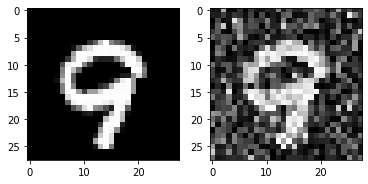

25  :  0.7320804518547281 25
50  :  0.7320804518547281 25
75  :  0.7320804518547281 25
100  :  0.7320804518547281 25
125  :  0.7320804518547281 25
150  :  0.7335911161873395 25
175  :  0.7335590421651003 25
200  :  0.7335590421651003 25
225  :  0.7335590421651003 25
250  :  0.7335590421651003 25
275  :  0.7335590421651003 25
300  :  0.7335590421651003 25
325  :  0.7335590421651003 25
350  :  0.7355894723287997 25
375  :  0.7362065800671642 25
400  :  0.7362065800671642 25
425  :  0.7362065800671642 25
450  :  0.7362065800671642 25
475  :  0.7362065800671642 25
500  :  0.7362065800671642 25
525  :  0.7362065800671642 25
550  :  0.7362065800671642 25
575  :  0.7362065800671642 25
600  :  0.7362065800671642 25
625  :  0.7362065800671642 25
650  :  0.7367328272645762 25
675  :  0.7370991425362832 25
700  :  0.7370991425362832 25
725  :  0.7370991425362832 25
750  :  0.7370991425362832 25
775  :  0.7372842133017609 25
800  :  0.7411327246802983 25
Time:  69.84464597702026  seconds
Predicted

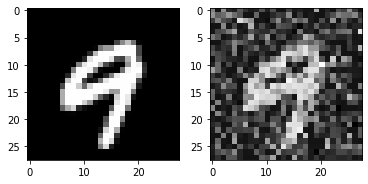

25  :  0.7145803984375825 25
50  :  0.7145803984375825 25
75  :  0.7145803984375825 25
100  :  0.7176905424171314 25
125  :  0.7145803984375825 25
150  :  0.7244620349614079 25
175  :  0.7244620349614079 25
200  :  0.7244620349614079 25
225  :  0.7251182878886422 25
250  :  0.7244620349614079 25
275  :  0.7255312351924352 25
300  :  0.725520213373211 25
325  :  0.7259348980988104 25
350  :  0.725520213373211 25
375  :  0.7280581626834985 25
400  :  0.7290598329789209 25
425  :  0.7290839141891041 25
450  :  0.7290839141891041 25
475  :  0.7294240992719184 25
500  :  0.7360320009270419 25
525  :  0.7331139974826134 25
550  :  0.7354282470982294 25
575  :  0.7355493361281844 25
600  :  0.7372597399050713 25
625  :  0.7372662935662453 25
650  :  0.738788416519818 25
675  :  0.7425241478060597 25
700  :  0.743036341599553 25
725  :  0.7434504951901053 25
750  :  0.7446198553187515 25
775  :  0.7445663013532811 25
800  :  0.7445663013532811 25
Time:  69.4971215724945  seconds
Predicted clas

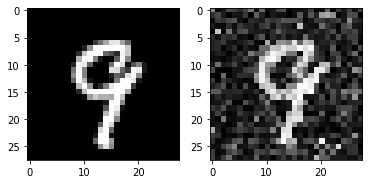

25  :  0.6970468131239234 25
50  :  0.6970468131239234 25
75  :  0.7014355922279237 25
100  :  0.7014355922279237 25
125  :  0.7014355922279237 25
150  :  0.7014355922279237 25
175  :  0.7017647430113837 25
200  :  0.7014355922279237 25
225  :  0.7014355922279237 25
250  :  0.7014355922279237 25
275  :  0.701780541532451 25
300  :  0.7028028302377789 25
325  :  0.7053419491238246 25
350  :  0.7060140111069085 25
375  :  0.7061771534157301 25
400  :  0.7063651161348636 25
425  :  0.7092014807058187 25
450  :  0.7088592095250608 25
475  :  0.7088592095250608 25
500  :  0.7088592095250608 25
525  :  0.7088592095250608 25
550  :  0.7119265372577073 25
575  :  0.7115197713981376 25
600  :  0.7114909377828254 25
625  :  0.7114909377828254 25
650  :  0.7121811678544572 25
675  :  0.7126473259953622 25
700  :  0.7124762913852201 25
725  :  0.7130073108564661 25
750  :  0.7146465610746212 25
775  :  0.7145866118634149 25
800  :  0.7145866118634149 25
Time:  69.44077348709106  seconds
Predicted 

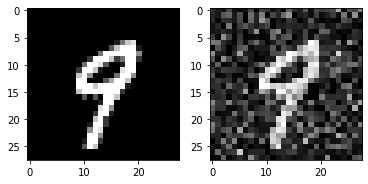

25  :  0.6969962725643919 25
50  :  0.6969962725643919 25
75  :  0.6969962725643919 25
100  :  0.6969962725643919 25
125  :  0.6969962725643919 25
150  :  0.6969962725643919 25
175  :  0.6991983416865747 25
200  :  0.6990923943208126 25
225  :  0.6990923943208126 25
250  :  0.7029964029143025 25
275  :  0.7028007023336018 25
300  :  0.7028007023336018 25
325  :  0.7028007023336018 25
350  :  0.7066594393088229 25
375  :  0.7066594393088229 25
400  :  0.7110080634462055 25
425  :  0.7110080634462055 25
450  :  0.712397957782372 25
475  :  0.7124500081719367 25
500  :  0.7124450105115373 25
525  :  0.7151558234724464 25
550  :  0.7151578715026115 25
575  :  0.7151578715026115 25
600  :  0.7151578715026115 25
625  :  0.7171240197705595 25
650  :  0.7171388168925104 25
675  :  0.7171388168925104 25
700  :  0.7171388168925104 25
725  :  0.718399130049706 25
750  :  0.7183980143095414 25
775  :  0.7187754131567086 25
800  :  0.719204502033651 25
Time:  68.69730710983276  seconds
Predicted cl

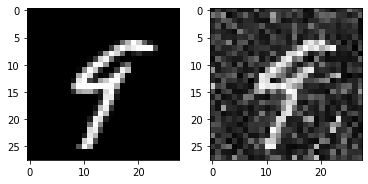

25  :  0.7042479036912923 25
50  :  0.7042479036912923 25
75  :  0.7086354700483647 25
100  :  0.7106103059199185 25
125  :  0.7104562918811799 25
150  :  0.7104562918811799 25
175  :  0.7121570418602791 25
200  :  0.7134405369245127 25
225  :  0.7141453362422145 25
250  :  0.7162451915828583 25
275  :  0.715490649180211 25
300  :  0.715490649180211 25
325  :  0.7171006469905441 25
350  :  0.7167208826826823 25
375  :  0.7197526008546979 25
400  :  0.7197325269029813 25
425  :  0.7197325269029813 25
450  :  0.7213791750740888 25
475  :  0.7224316462869771 25
500  :  0.7221223870978836 25
525  :  0.7243651594076221 25
550  :  0.7262944863954193 25
575  :  0.7285689361721333 25
600  :  0.7277821680984138 25
625  :  0.7324153495639306 25
650  :  0.7322452530156015 25
675  :  0.7322452530156015 25
700  :  0.7323267482290078 25
725  :  0.7344138555733681 25
750  :  0.7348177698614737 25
775  :  0.7348177698614737 25
800  :  0.7349481250468568 25
Time:  70.01420760154724  seconds
Predicted c

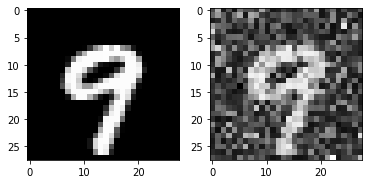

25  :  0.6887677246071217 25
50  :  0.6887677246071217 25
75  :  0.6887677246071217 25
100  :  0.6887677246071217 25
125  :  0.6894451495810265 25
150  :  0.6894451495810265 25
175  :  0.6894451495810265 25
200  :  0.6894451495810265 25
225  :  0.6911666966813949 25
250  :  0.6911666966813949 25
275  :  0.6911666966813949 25
300  :  0.6911666966813949 25
325  :  0.6911666966813949 25
350  :  0.691369607344058 25
375  :  0.700593615920703 25
400  :  0.7005900329950949 25
425  :  0.7005900329950949 25
450  :  0.7005900329950949 25
475  :  0.7005900329950949 25
500  :  0.7005900329950949 25
525  :  0.702568255282183 25
550  :  0.7028034658391058 25
575  :  0.7045077633988035 25
600  :  0.7043261095774065 25
625  :  0.7043261095774065 25
650  :  0.7043261095774065 25
675  :  0.7046668461281734 25
700  :  0.7063567748909896 25
725  :  0.7063601560924558 25
750  :  0.7079133732262621 25
775  :  0.7129673746094097 25
800  :  0.7129673746094097 25
Time:  69.93819212913513  seconds
Predicted cl

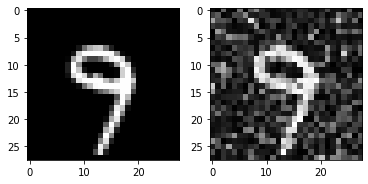

25  :  0.7438203254113523 25
50  :  0.7438203254113523 25
75  :  0.7438203254113523 25
100  :  0.7465244708523983 25
125  :  0.7539845916087713 25
150  :  0.7539845916087713 25
175  :  0.7539845916087713 25
200  :  0.7539845916087713 25
225  :  0.7571812912715837 25
250  :  0.7578356388974283 25
275  :  0.7619317083775861 25
300  :  0.7616429829274736 25
325  :  0.7618660317407606 25
350  :  0.7618660317407606 25
375  :  0.7671249485279799 25
400  :  0.7677777031984677 25
425  :  0.7697853657442875 25
450  :  0.7696818142340613 25
475  :  0.7696818142340613 25
500  :  0.7696818142340613 25
525  :  0.7697949856511684 25
550  :  0.7736649642300326 25
575  :  0.7745328154833355 25
600  :  0.7762574518240571 25
625  :  0.7761364749494521 25
650  :  0.7761364749494521 25
675  :  0.776309154791964 25
700  :  0.7764814065184538 25
725  :  0.777312764553778 25
750  :  0.777312764553778 25
775  :  0.777766845648445 25
800  :  0.7777596416241023 25
Time:  72.44566559791565  seconds
Predicted cla

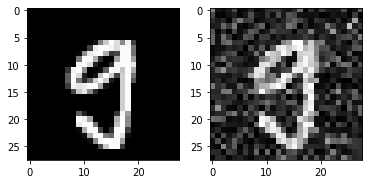

25  :  0.7161913168612102 25
50  :  0.7161913168612102 25
75  :  0.7161913168612102 25
100  :  0.7161913168612102 25
125  :  0.7161913168612102 25
150  :  0.7161913168612102 25
175  :  0.7161913168612102 25
200  :  0.7161913168612102 25
225  :  0.7175024298640913 25
250  :  0.7188201351728424 25
275  :  0.720982063349304 25
300  :  0.7212166958941765 25
325  :  0.7246560989124482 25
350  :  0.7246560989124482 25
375  :  0.7246560989124482 25
400  :  0.7246560989124482 25
425  :  0.7250082449114665 25
450  :  0.72663298528935 25
475  :  0.72663298528935 25
500  :  0.72663298528935 25
525  :  0.7270851318848868 25
550  :  0.7270946640612033 25
575  :  0.7302088899492931 25
600  :  0.7302022930567 25
625  :  0.7322058906397386 25
650  :  0.7320425825173925 25
675  :  0.7332082782758893 25
700  :  0.7332082782758893 25
725  :  0.7344245877195672 25
750  :  0.7347127801569521 25
775  :  0.7347322259911522 25
800  :  0.7359942970609846 25
Time:  72.46436858177185  seconds
Predicted class:  [

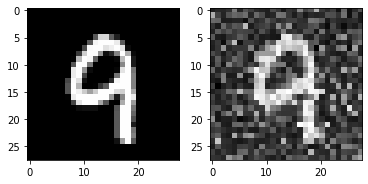

25  :  0.7490798486359711 25
50  :  0.7490798486359711 25
75  :  0.7502266731151658 25
100  :  0.7502266731151658 25
125  :  0.7502266731151658 25
150  :  0.7502266731151658 25
175  :  0.7502266731151658 25
200  :  0.7502266731151658 25
225  :  0.7502266731151658 25
250  :  0.7502266731151658 25
275  :  0.7502266731151658 25
300  :  0.7502266731151658 25
325  :  0.7502266731151658 25
350  :  0.7502266731151658 25
375  :  0.7502266731151658 25
400  :  0.7502266731151658 25
425  :  0.7502310269120883 25
450  :  0.7502310269120883 25
475  :  0.7502310269120883 25
500  :  0.7526160620984892 25
525  :  0.7526351390196455 25
550  :  0.7541663791613618 25
575  :  0.7551536352145498 25
600  :  0.755727267982133 25
625  :  0.7566652195619581 25
650  :  0.7579583355962267 25
675  :  0.7595930530564681 25
700  :  0.7609845835667481 25
725  :  0.7617530572239761 25
750  :  0.7617400232282301 25
775  :  0.7622404883597487 25
800  :  0.7622850925654513 25
Time:  71.5433201789856  seconds
Predicted c

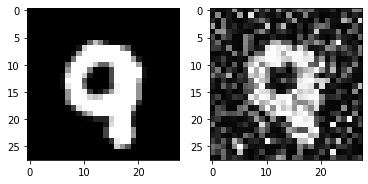

In [20]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28,28,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_cnn_mnist_ssim', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [22]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

120.25090742111206
55.84380888938904
74.7170508872895
9.28551848591983


In [23]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1463
800
860.952380952381
106.87456355747568


In [24]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

14.992255595813022
9.409214055922298
12.108511452864693
1.3397401005663647
